<a href="https://colab.research.google.com/github/pkang0831/Data_Science_Projects/blob/main/BasetwoAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Basetwoai take home challenge: penicillin dataset

This particular document involves study of the penicillin batch processing, using the given dataset as mentioned in the acknowledgement. 

**Prepared by:** Paul Kang

**Prepared for:** BasetwoAI


## 0. contents

Below is a list of contents showing how this and the following notebooks documenting the project execution are structured:

1. Introduction
2. Data Ingestion

> 2.1 Column headers

> 2.2 Descriptive stats for further cleaning

3. Exploratory Data Analysis (EDA)

> 3.1 Target Variable Identification

> 3.2 Batch Partitioning

>> 3.2.1 Differencing

>> 3.2.2 Steady State vs Non-Equlibrium Runs

> 3.3 Batch Level Models (BLM) vs Batch Evolution Models (BEM)

> 3.4 Histogram of each predictor variables

> 3.5 Confounding/Alias

> 3.6 Classifications of target variables

> 3.7 PCA enabled K-means clustering (validation)

4. Final Observations and Remarks

# 1. Introduction
This particular document involves study of the penicillin batch processing, using the given dataset as mentioned in the acknowledgement.

Acknowledgement:
The given dataset was generated by Stephen Goldrick at UCL Biochemical Society. 


# 2. Data Ingestion

With the given dataset, it is important to see if each of the predictor variables and the target variables are identified, what are their expected data profiles and etc. These jobs will be done by exploring descriptive statistics first for each variables in the given dataset.


dataset shapes: 113935 records with 40 fields, fairly small, so I will handle them using pandas library


In [243]:
# import the necessary libraries

# base libraries
import pandas as pd
import numpy as np
import re
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')

# Hypothesis testing - one way
import scipy as sp

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
%matplotlib inline

# import pca-kmeans libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

data = pd.read_csv('/pencillin_dataset.csv')

In [244]:
def dataProfiling(df: pd.DataFrame) -> pd.DataFrame:
    """
    Description: quick profile overview of data quality
    Args:
        - df: pd.DataFrame == raw data
    Output:
        - data_profiles == profiles that I want to view
    """
    df = df.copy(deep = True)
    # Check nulls
    _nulls = pd.DataFrame(round(df.isnull().sum()/len(df)*100,2),columns=['null percentage'])
    _dtypes = pd.DataFrame(df.dtypes,columns=['data type'])

    # Duplicated?
    _duplicates = pd.DataFrame([df[i].duplicated().sum() for i in df.columns],columns = ['Duplicate Entries'],index = df.columns)

    # Categorical or Numerical?
    numeric_entries = set(df._get_numeric_data().columns)
    categorical_entries = set(df.columns).difference(numeric_entries)
    _dataform = pd.DataFrame(['Numerical' if i in numeric_entries else 'Categorical' for i in df.columns],columns = ['Num_or_Cat'],index = df.columns)

    # Number of unique values for each variables; max is len(df)
    _unique = pd.DataFrame([len(df[i].unique().tolist()) for i in df.columns], columns = ['Value_counts'],index = df.columns)

    # if the variable exhibits low cardinality, show their values
    _unique_vals = []
    _unique_val_counts = []
    for i in df.columns:
        if len(df[i].unique().tolist()) > 100:
            _unique_vals.append('High cardinality')
            _unique_val_counts.append('Too much unique_values')
        else:
            _unique_vals.append(df[i].unique().tolist())
            _unique_val_counts.append(df[i].value_counts().tolist())

    _unique_values = pd.DataFrame(_unique_vals, columns = ['Unique_values'], index = df.columns)
    _unique_val_counts_vals = pd.DataFrame(_unique_val_counts, columns = ['Unique_value_counts'], index = df.columns)

    # Concat every info
    data_profiles = pd.concat([_nulls,_dtypes,_duplicates,_dataform,_unique, _unique_values, _unique_val_counts_vals], axis = 1)

    return data_profiles

In [245]:
# dataset shapes
data.shape

# Check the data profiles

df_profile = dataProfiling(data)
df_profile

null percentage data type  \
Unnamed: 0                                                     0.00     int64   
Time (h)                                                       0.00   float64   
Aeration rate(Fg:L/h)                                          0.00     int64   
Agitator RPM(RPM:RPM)                                          0.00     int64   
Sugar feed rate(Fs:L/h)                                        0.00     int64   
Acid flow rate(Fa:L/h)                                         0.00   float64   
Base flow rate(Fb:L/h)                                         0.00   float64   
Heating/cooling water flow rate(Fc:L/h)                        0.00   float64   
Heating water flow rate(Fh:L/h)                                0.00   float64   
Water for injection/dilution(Fw:L/h)                           0.00     int64   
Air head pressure(pressure:bar)                                0.00   float64   
Dumped broth flow(Fremoved:L/h)                                0.00     int64   
Substrate concentration(S:g/L)                                 0.00   float64   
Dissolved oxygen concentration(DO2:mg/L)                       0.00   float64   
Penicillin concentration(P:g/L)                                0.00   float64   
Vessel Volume(V:L)                                             0.00     int64   
Vessel Weight(Wt:Kg)                                           0.00     int64   
pH(pH:pH)                                                      0.00   float64   
Temperature(T:K)                                               0.00   float64   
Generated heat(Q:kJ)                                           0.00   float64   
carbon dioxide percent in off-gas(CO2outgas:%)                 0.00   float64   
PAA flow(Fpaa:PAA flow (L/h))                                  0.00   float64   
PAA concentration offline(PAA_offline:PAA (g L^...            98.19   float64   
Oil flow(Foil:L/hr)                                            0.00     int64   
NH_3 concentration off-line(NH3_offline:NH3 (g ...            98.19   float64   
Oxygen Uptake Rate(OUR:(g min^{-1}))                           0.00   float64   
Oxygen in percent in off-gas(O2:O2  (%))                       0.00   float64   
Offline Penicillin concentration(P_offline:P(g ...            98.19   float64   
Offline Biomass concentratio(X_offline:X(g L^{-...            98.19   float64   
Carbon evolution rate(CER:g/h)                                 0.00   float64   
Ammonia shots(NH3_shots:kgs)                                   0.00     int64   
Viscosity(Viscosity_offline:centPoise)                        98.19   float64   
0 - Recipe driven 1 - Operator controlled(Contr...             0.00     int64   
Fault reference(Fault_ref:Fault ref)                           0.00     int64   
1- No Raman spec                                               0.00     int64   
1-Raman spec recorded                                          0.00     int64   
2-PAT control(PAT_ref:PAT ref)                                 0.00     int64   
Batch reference(Batch_ref:Batch ref)                           0.00     int64   
Batch ID                                                       0.00     int64   
Fault flag                                                     0.00     int64   

                                                    Duplicate Entries  \
Unnamed: 0                                                          0   
Time (h)                                                       112485   
Aeration rate(Fg:L/h)                                          113928   
Agitator RPM(RPM:RPM)                                          113934   
Sugar feed rate(Fs:L/h)                                        113910   
Acid flow rate(Fa:L/h)                                         112582   
Base flow rate(Fb:L/h)                                          46729   
Heating/cooling water flow rate(Fc:L/h)                         36555   
Heating water flow rate(Fh:L/h)                                 59401   


## 2.1 Column headers

There are some observations for the first overview:

0. "Unnamed: 0" should be dropped as it seems to indicate the row counts.

1. Every variables are in numerical format, most of the variable shows high cardinality and some are binary. After taking a closer look at the last few columns, it seems that some columns are misaligned. 

2. looking at the column: "1-No Raman spec" it has the unique values of 1 and 2 which seems to be the column that needs to be for "1-Raman spec recorded" and "2-PAT control(PAT_ref:PAT ref)", and the records that are in those two columns should be aligned with the "Batch reference(Batch_ref: Batch_ref)" and "Batch ID". This is because we know that all the batch runs are in a range of 1 - 100.

3. Some process variables that shows only 1 unique value will be dropped because this 1 cardinality does not provide any information (Ammonia shots and Agitator RPM)

After fixing some column names, we will drop the last 2 column because it seems to be a parsing error when the table was queried. 

Then what happens with the Fault reference(Fault_ref:Fault ref) and the data with the "Batch reference(Batch_ref:Batch ref)?

Lets plot those two and see if they show something


In [246]:
# rename the columns
data.rename(columns = {
    '1- No Raman spec': '1-Raman spec recorded / 2-PAT control(PAT_ref:PAT ref)_fixed',
    '1-Raman spec recorded': 'Batch reference(Batch_ref:Batch ref)_fixed',
    '2-PAT control(PAT_ref:PAT ref)': 'Batch ID_fixed',
    'Batch reference(Batch_ref:Batch ref)': 'Fault flag_fixed'
    }, inplace = True)

In [247]:
# Also, drop the first column
data = data.drop("Unnamed: 0", axis = 1)
# Drop the process variable that does not show any cardinality 
data = data.drop(["Agitator RPM(RPM:RPM)","Ammonia shots(NH3_shots:kgs)"], axis = 1)
# Drop the last two columns
data = data.drop(['Batch ID','Fault flag'], axis = 1)

In [248]:
# before I go ahead and apply this change to the original dataframe, I also want to study the relationship between the Fault Reference and the Fault flag.
# apply line plots for each

fig = make_subplots(rows=2, cols=1)

fig.add_trace(
    go.Scatter(x = data.index, y = data['Fault reference(Fault_ref:Fault ref)'], name = 'Fault reference'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x = data.index, y = data['Fault flag_fixed'], name = 'Fault flag_fixed'),
    row=2, col=1
)

fig.update_layout(
    height=600, 
    width=800, 
    title_text="Fault reference Vs Fault flag")

fig.show()

I am not sure the whole context behind of this situation, however it seems that those two variables are indicative of the batch runs that have the faultiness.

I will go deep dive into this matter if necessary in the subsequent analysis, but lets leave this for now.



## 2.2 Descriptive stats for further cleaning

In [249]:
from pandas.core.indexes import interval
data.describe(percentiles = [i/10 for i in range(1,11,2)]).T

count          mean  \
Time (h)                                            113935.0    114.750656   
Aeration rate(Fg:L/h)                               113935.0     65.246360   
Sugar feed rate(Fs:L/h)                             113935.0     76.663764   
Acid flow rate(Fa:L/h)                              113935.0      0.073209   
Base flow rate(Fb:L/h)                              113935.0     61.334389   
Heating/cooling water flow rate(Fc:L/h)             113935.0     74.346341   
Heating water flow rate(Fh:L/h)                     113935.0     20.763025   
Water for injection/dilution(Fw:L/h)                113935.0    154.811954   
Air head pressure(pressure:bar)                     113935.0      0.945026   
Dumped broth flow(Fremoved:L/h)                     113935.0   -214.508272   
Substrate concentration(S:g/L)                      113935.0      4.079817   
Dissolved oxygen concentration(DO2:mg/L)            113935.0     12.569647   
Penicillin concentration(P:g/L)                     113935.0     14.333946   
Vessel Volume(V:L)                                  113935.0  73312.865441   
Vessel Weight(Wt:Kg)                                113935.0  81076.728512   
pH(pH:pH)                                           113935.0      6.496565   
Temperature(T:K)                                    113935.0    298.026489   
Generated heat(Q:kJ)                                113935.0    279.072562   
carbon dioxide percent in off-gas(CO2outgas:%)      113935.0      1.444042   
PAA flow(Fpaa:PAA flow (L/h))                       113935.0      7.642712   
PAA concentration offline(PAA_offline:PAA (g L^...    2062.0   1887.750349   
Oil flow(Foil:L/hr)                                 113935.0     26.352789   
NH_3 concentration off-line(NH3_offline:NH3 (g ...    2062.0   1961.843259   
Oxygen Uptake Rate(OUR:(g min^{-1}))                113935.0      1.258208   
Oxygen in percent in off-gas(O2:O2  (%))            113935.0      0.191458   
Offline Penicillin concentration(P_offline:P(g ...    2062.0     14.439449   
Offline Biomass concentratio(X_offline:X(g L^{-...    2062.0     18.799095   
Carbon evolution rate(CER:g/h)                      113935.0      1.250103   
Viscosity(Viscosity_offline:centPoise)                2062.0     51.546454   
0 - Recipe driven 1 - Operator controlled(Contr...  113935.0      0.301795   
Fault reference(Fault_ref:Fault ref)                113935.0      0.011024   
1-Raman spec recorded / 2-PAT control(PAT_ref:P...  113935.0      1.295783   
Batch reference(Batch_ref:Batch ref)_fixed          113935.0     50.402466   
Batch ID_fixed                                      113935.0     50.402466   
Fault flag_fixed                                    113935.0      0.101154   

                                                             std  \
Time (h)                                               66.990504   
Aeration rate(Fg:L/h)                                  11.690215   
Sugar feed rate(Fs:L/h)                                25.680134   
Acid flow rate(Fa:L/h)                                  0.552788   
Base flow rate(Fb:L/h)                                 44.972713   
Heating/cooling water flow rate(Fc:L/h)               108.022600   
Heating water flow rate(Fh:L/h)                        50.230266   
Water for injection/dilution(Fw:L/h)                  155.601474   
Air head pressure(pressure:bar)                         0.134269   
Dumped broth flow(Fremoved:L/h)                       901.125084   
Substrate concentration(S:g/L)                         13.303517   
Dissolved oxygen concentration(DO2:mg/L)                1.498680   
Penicillin concentration(P:g/L)                         9.932453   
Vessel Volume(V:L)                                   8599.642160   
Vessel Weight(Wt:Kg)                                10097.227390   
pH(pH:pH)                                               0.065676   
Temperature(T:K)                                        0.197513   
Generated heat(Q:kJ)  

Observation:

1. for different variables, some variables are showing the outlier behavior (90% vs Max numerical values being very different), however it is premature to determine if they should be dropped or not, without knowing if those outliers are truly a influencer or an actual outlier. variable by variable study needs to be done for every different batch.

2. Variable that contains "_offline" header seems to be a variable that involves a snapshot sample of the continuous runs. this data type is very common in chemical engineering datasets, so we will determine either ffill or aggregate average them per batch.


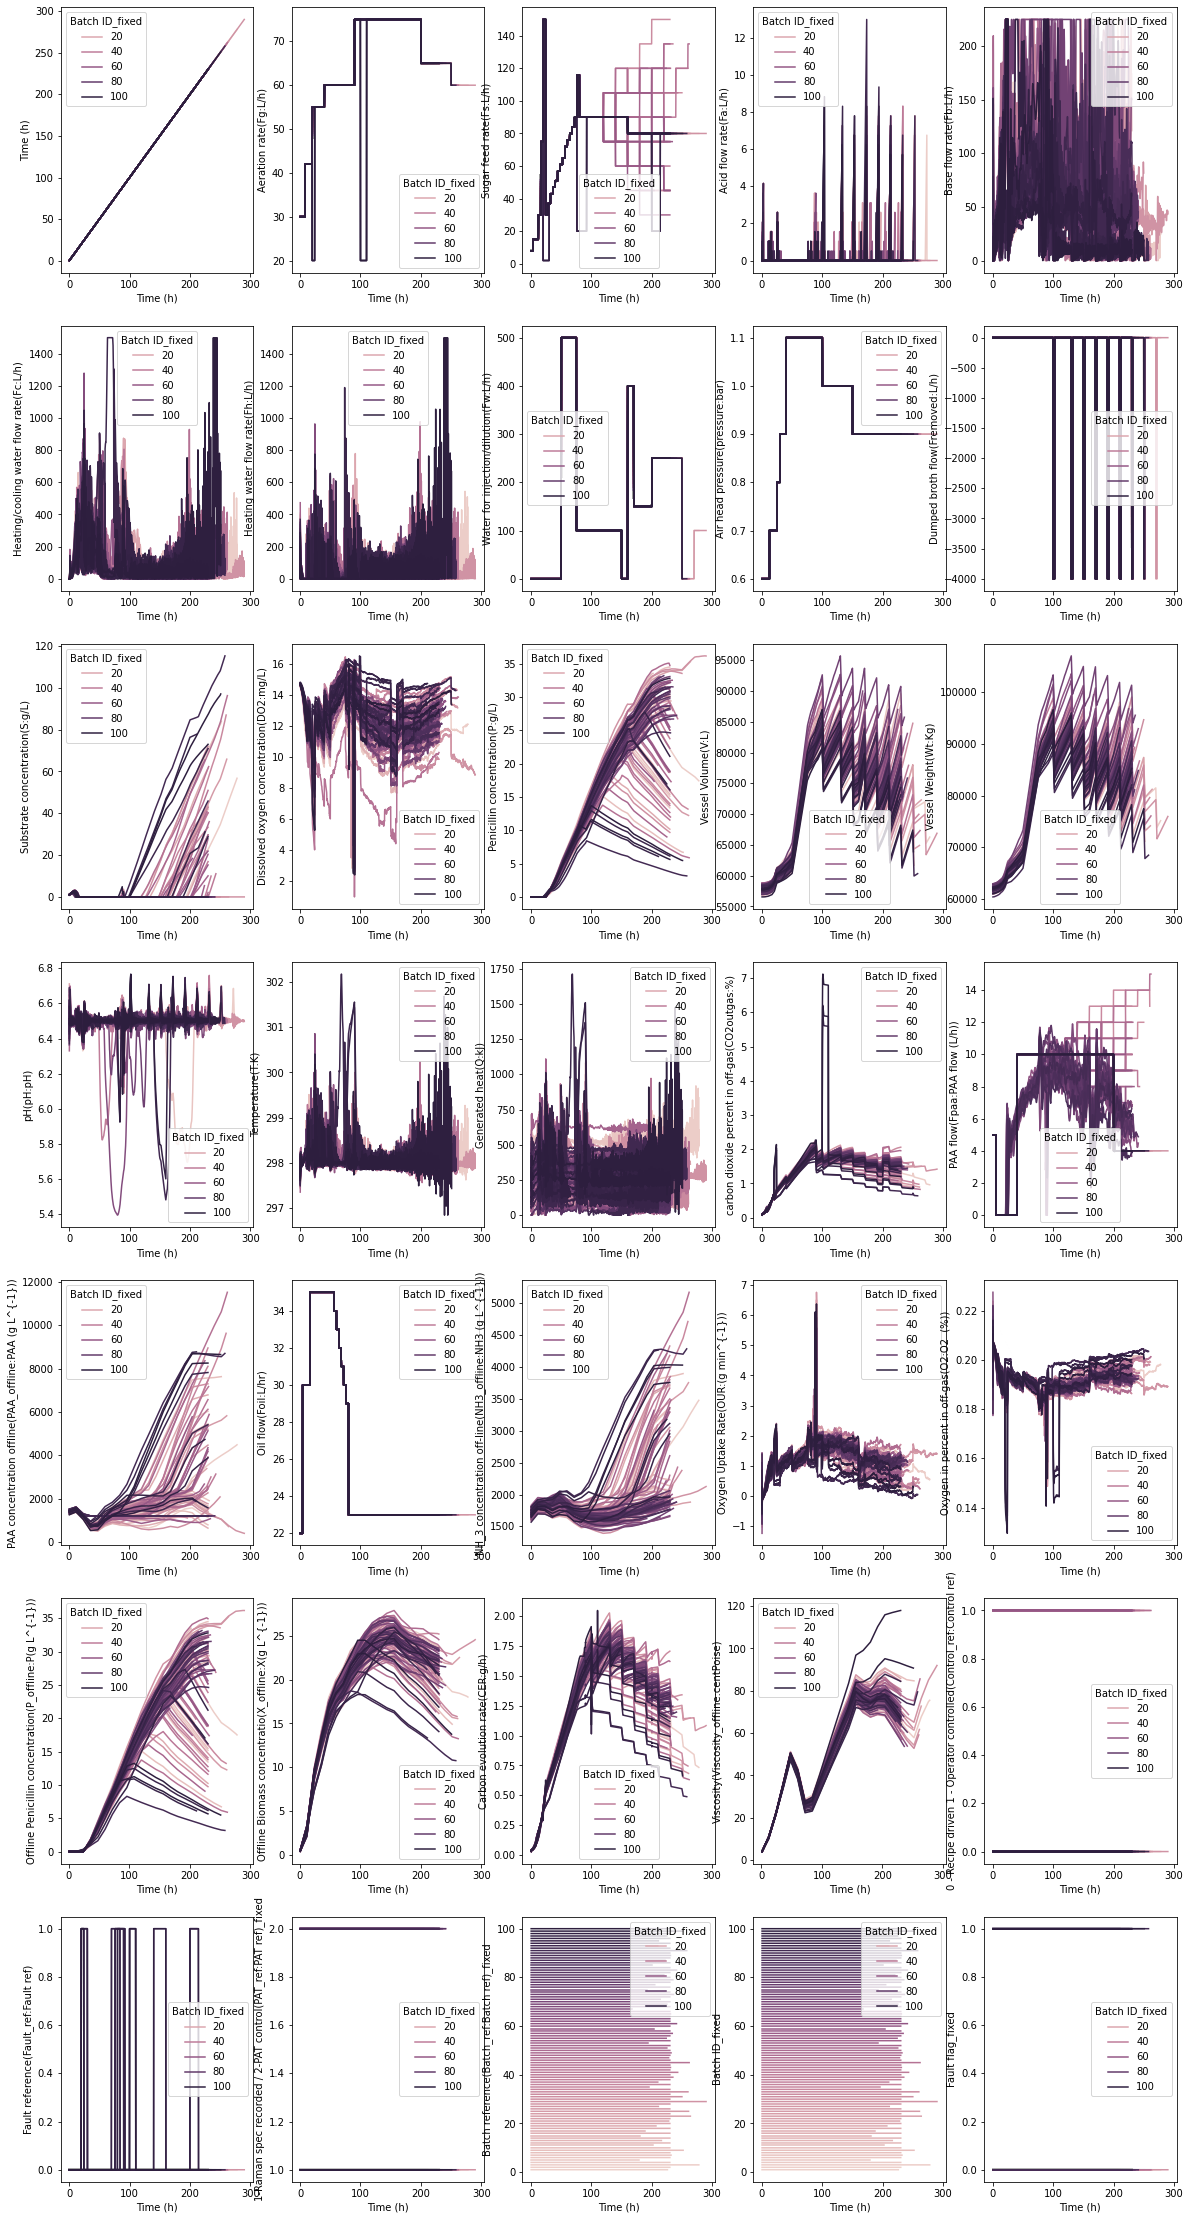

In [250]:
fig, ax = plt.subplots(7,5,figsize = (20,40))

for col, ax in zip(data.columns, ax.flatten()):
    sns.lineplot(x = data['Time (h)'], y = col, hue = 'Batch ID_fixed', data = data, ax = ax)

There are some further variable drops that can be made after looking at the combined plots for each different batch runs.

Process Variable that demonstrates consistency for every batch runs:
1. 'Aeration rate(Fg:L/h)'
2. 'Water for injection/dilution(Fw:L/h)'
3. 'Dumped broth flow(Fremoved:L/h)'
4. 'Air head pressure(pressure:bar)'
5. 'Oil flow(Foil:L/hr)'

Also, we can contemplate a bit here for the expected ranges of each variable.

in this data, this is indeed a batch analysis but for every batch, it can be argued that they are 100 different time series data with the fact that subsequent change of setpoints can affect the target variable's behavior in the future. therefore, instead of dropping those outliers, we can manage to aggregate them OR we bring the idea of statistical process control (SPC) and measure those spikes, and incorporate them in further deep dive.

However, this study is a preliminary analysis to see the general trend of the target variable behavior for different setpoints of the predictors. For the sake of similicity in this study, we will aggregate them.

In [251]:
# drop the identfied column from above:
data = data.drop(
    [
        'Aeration rate(Fg:L/h)', 
        'Water for injection/dilution(Fw:L/h)', 
        'Dumped broth flow(Fremoved:L/h)', 
        'Air head pressure(pressure:bar)',
        'Oil flow(Foil:L/hr)'
    ]
    , axis = 1)
# drop the metadata of the each batch runs
data = data.drop(
    [
        '0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref)',
        '1-Raman spec recorded / 2-PAT control(PAT_ref:PAT ref)_fixed',
        'Batch reference(Batch_ref:Batch ref)_fixed',
        'Fault reference(Fault_ref:Fault ref)'
    ]
    , axis = 1)

# 3.0 Exploratory Data Analysis (EDA)

## 3.1 Target Variable Identification

Recall the objective of this study:

 - what set of variable combination that yields highest yield of penicillin?

From here, we can take a closer look at following variables:

1. 'Penicillin concentration(P:g/L)'

2. 'Offline Penicillin concentration(P_offline:P(g L^{-1}))'

3. 'Offline Biomass concentratio(X_offline:X(g L^{-1}))' - this is selected because it showed similar behavior of the offline penicillin concentration

Except for the penicillin concentration, other variables are the snapshot samples of the process variables. for analysing the sensory data, we will use the signal that shows continuous behavior, which is: 'Penicillin concentration(P:g/L)'.

Lets take a closer look at the penicillin concentration



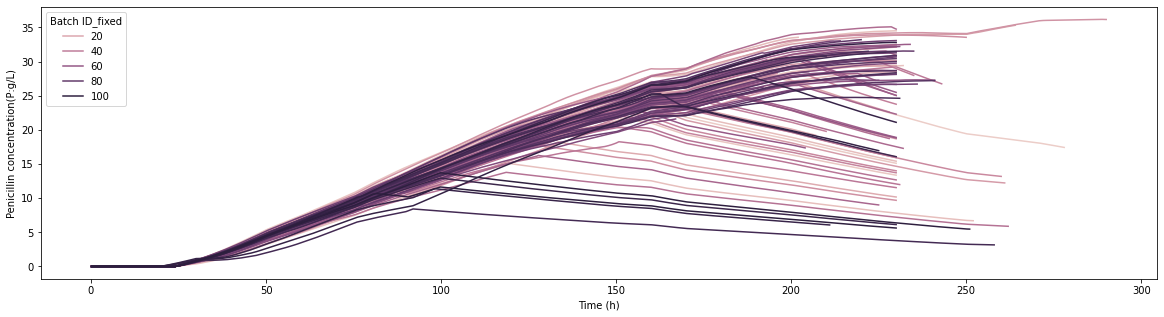

In [252]:
fig, ax = plt.subplots(figsize = (20,5))

sns.lineplot(x = data['Time (h)'], y = 'Penicillin concentration(P:g/L)', hue = 'Batch ID_fixed', data = data, ax = ax)

Clearly, we see a different outcomes of each batch of the penicillin evolution. 

one behavior shows a steady evolution rate that reaches plateau of the concentration, and the other one reaches its max point and start to degrade. in chemical engineering world, we call this behavior equilibrium vs non-equlibrium (steady state vs non steady state).

Of course, when we look at this data, it seems we can easily think that:

 - we can just select the ones that reached equilibrium and see what the process variable looks like to reach that point?

In academia world, where theoretical/ideal condition to be found, **Yes**, in industrial manufacturing, where maximum value to be generated, **No**

Let me bring a hypothetical example:
1. Let say that we have identified perfect condition where we can produce maximum pencilin concentration that takes 240 hours.
2. We found another condition where we reached 90% of the theoretical yield of pencilin in 200 hours or less.

which one is more profitable for the business? Of course, we would have to take further variables to make a break even point, (such as.. maintenance costs of the equipments and MTBF of the vessels.. and etc) but Lets leave this thinking path for now. 


I will frame this as batch that reached equilibrium vs non-equilibrium

## 3.2 Batch Partitioning

As above, lets partition the data where the batch reached steady state or not. to do this, we have to know what is the most apparent difference between those two: change of slope!!!

well this is where we bring an idea of differencing in every batch. after few experimental runs, I have identified that differencing of 50 steps with 15% of its negative slope identified in each batch run makes a good line between those two subsets.

In [253]:
# lets divide batches by batches

dfs = []

for i in range(1,101):
    batch_df = data[data['Batch ID_fixed'] == i]
    dfs.append(batch_df)

### 3.2.1 Differencing

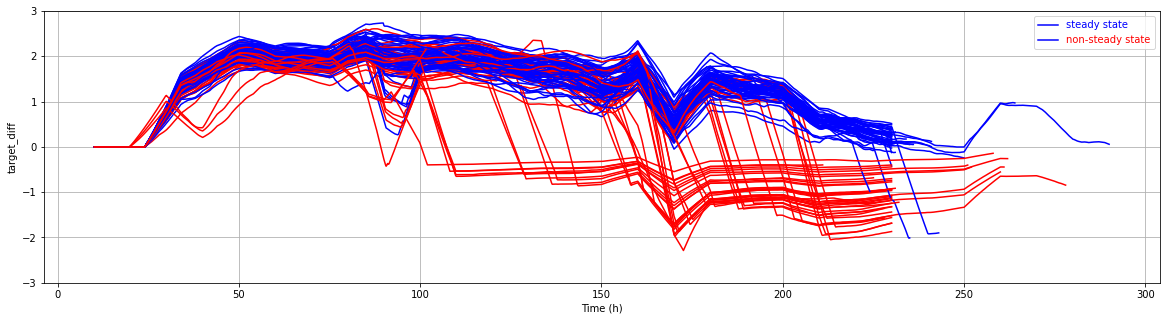

In [254]:
# From the plots we can definitely see that a lot of values that is denoted as 1 in the fault flag has the early stopping condition of the target variable. However, this nature is also apparent in the "no fault"
# conditions as well, so I believe partitioning of the data is important and do separate analysis for those two types

# to seprate them out, the major difference that I see is the slope change. so I am going to differentiate the target variable.

for df in dfs:
    df['target_diff'] = df['Penicillin concentration(P:g/L)'].diff(50)
    if len(df[df['target_diff'] <= 0]) > 0.15*len(df):
        df['faulty_condition'] = 1
    else:
        df['faulty_condition'] = 0

fig, ax = plt.subplots(figsize = (20,5))
for df in dfs:
    if df['faulty_condition'].sum() > 0:
        sns.lineplot(x = df['Time (h)'], y = 'target_diff', data = df, color = 'red')
    else:
        sns.lineplot(x = df['Time (h)'], y = 'target_diff', data = df, color = 'blue')
plt.ylim([-3,3])

leg = plt.legend(['steady state','non-steady state'])
leg_color = ['blue','red']
for text, color in zip(leg.get_texts(), leg_color):
    text.set_color(color)

plt.grid(True)

### 3.2.2 Steady State vs Non-Equlibrium Runs

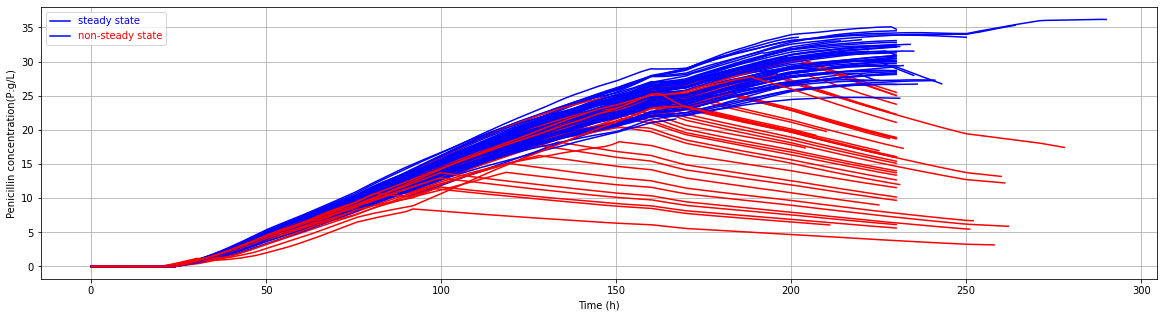

In [255]:
# How does this looks like in an actual data?

fig, ax = plt.subplots(figsize = (20,5))
for df in dfs:
    if df['faulty_condition'].sum() > 0:
        sns.lineplot(x = df['Time (h)'], y = 'Penicillin concentration(P:g/L)', data = df, color = 'red')
    else:
        sns.lineplot(x = df['Time (h)'], y = 'Penicillin concentration(P:g/L)', data = df, color = 'blue')
        
leg = plt.legend(['steady state','non-steady state'])
leg_color = ['blue','red']
for text, color in zip(leg.get_texts(), leg_color):
    text.set_color(color)

plt.grid(True)

For this study, I will partition the data into two subsets, steady state vs non steady state, and study each variable behavior.

Furthermore, when we take a closer look at the data, it seems the target variable shows its change after 24 hours of the batch runs. we will drop the first 24 hours for every runs. Also, any readings that are outside of 230 hours will be cut.

In [256]:
# group the data by fault conditions
df_steady = pd.DataFrame()
df_non_steady = pd.DataFrame()

for df in dfs:
    # reset index
    df = df.reset_index(drop = True)
    # drop first 24 hours
    df = df.iloc[120:,:].reset_index(drop = True)
    # drop last hours that are not consistent
    df = df[df['Time (h)'] <= 230].reset_index(drop = True)
    if df['faulty_condition'][0] == 0:
        df_steady = df_steady.append(df)

    else:
        df_non_steady = df_non_steady.append(df)

df_steady = df_steady.reset_index(drop = True)
df_non_steady = df_non_steady.reset_index(drop = True)
df_steady = df_steady.drop(['target_diff','faulty_condition'], axis = 1)
df_non_steady = df_non_steady.drop(['target_diff','faulty_condition'], axis = 1)

master_data = df_steady.append(df_non_steady)

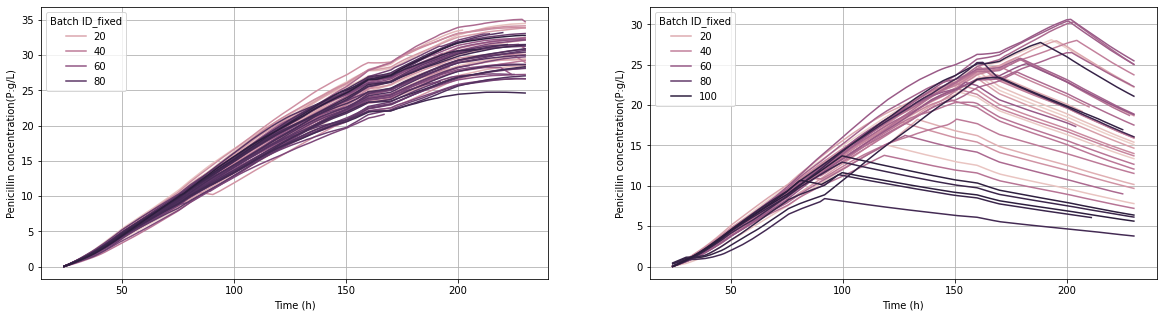

In [257]:
fig, ax = plt.subplots(1,2, figsize = (20,5))
plt.subplot(1,2,1)
sns.lineplot(x = 'Time (h)', y = 'Penicillin concentration(P:g/L)', hue = 'Batch ID_fixed', data = df_steady)
plt.grid(True)
plt.subplot(1,2,2)
sns.lineplot(x = 'Time (h)', y = 'Penicillin concentration(P:g/L)', hue = 'Batch ID_fixed', data = df_non_steady)
plt.grid(True)

## 3.3 Batch Level Models (BLM) vs Batch Evolution Models (BEM)

Idea of statistical process control can also be implemented here.
In a world of chemical engineering, CSTR / Batch operation, out of many statistical techinique that we can implement, it gets majorly divided into 2

1. Batch Evolution Models (BEM)
> this analysis method involves analysis of the time cross-sectional data for each different variables and see how they have impacted to the yield over time. This involves unfolding of the variables which may involve a large memory... 

2. **Batch Level Models (BLM)** (selected in this study)
> By going through each different predictor variables, we determine which descriptive nature of each variable will well represent final condition of the batch runs. For example, for penicillin concentration, maximum point can be taken as it is showing the cumulative nature, pH, temperature can be taken as mean and so on. Of course, in this manner, we are at danger zone of losing information since we are discarding a lot of data points with assumption that a single statistical parameter will represent the batch run.

In this preliminary analysis, I will first tackle the batch level models. For this type of analysis, each variable aggregation to represent the final condition of each run needs to be made, so list will be created.

also, some engineered features will be added to study each variable's behavior using idea of descriptive statistics and some signal processing knowledge.

General rule of thumb: for continuous variable, unless otherwise, use mean.

For our target variable, we will pick the max value.

In [258]:
apply_functions = {
    'Time (h)': 'mean',
    'Sugar feed rate(Fs:L/h)': 'mean',
    'Acid flow rate(Fa:L/h)': 'sum', # because this seems that it is a injection shot based, we want to know total amount of acids that we supplied
    'Base flow rate(Fb:L/h)': 'mean',
    'Heating/cooling water flow rate(Fc:L/h)': 'mean',
    'Heating water flow rate(Fh:L/h)': 'mean',
    'Substrate concentration(S:g/L)': 'mean',
    'Dissolved oxygen concentration(DO2:mg/L)': 'mean',
    'Penicillin concentration(P:g/L)': 'max',
    'Vessel Volume(V:L)': 'mean',
    'Vessel Weight(Wt:Kg)': 'mean',
    'pH(pH:pH)': 'mean',
    'Temperature(T:K)': 'mean',
    'Generated heat(Q:kJ)': 'mean',
    'carbon dioxide percent in off-gas(CO2outgas:%)': 'mean',
    'PAA flow(Fpaa:PAA flow (L/h))': 'mean',
    'PAA concentration offline(PAA_offline:PAA (g L^{-1}))': 'mean',
    'NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))': 'mean',
    'Oxygen Uptake Rate(OUR:(g min^{-1}))': 'mean',
    'Oxygen in percent in off-gas(O2:O2  (%))': 'mean',
    'Offline Penicillin concentration(P_offline:P(g L^{-1}))': 'mean',
    'Offline Biomass concentratio(X_offline:X(g L^{-1}))': 'mean',
    'Carbon evolution rate(CER:g/h)': 'mean',
    'Viscosity(Viscosity_offline:centPoise)': 'mean',
    'Batch ID_fixed': 'mean',
    'Fault flag_fixed': 'mean'
}
df_steady_fe = df_steady.groupby(['Batch ID_fixed']).agg(apply_functions)
df_non_steady_fe = df_non_steady.groupby(['Batch ID_fixed']).agg(apply_functions)
df_steady_fe = df_steady_fe.reset_index(drop = True)
df_non_steady_fe = df_non_steady_fe.reset_index(drop = True)

## 3.4 Histogram of each predictor variables

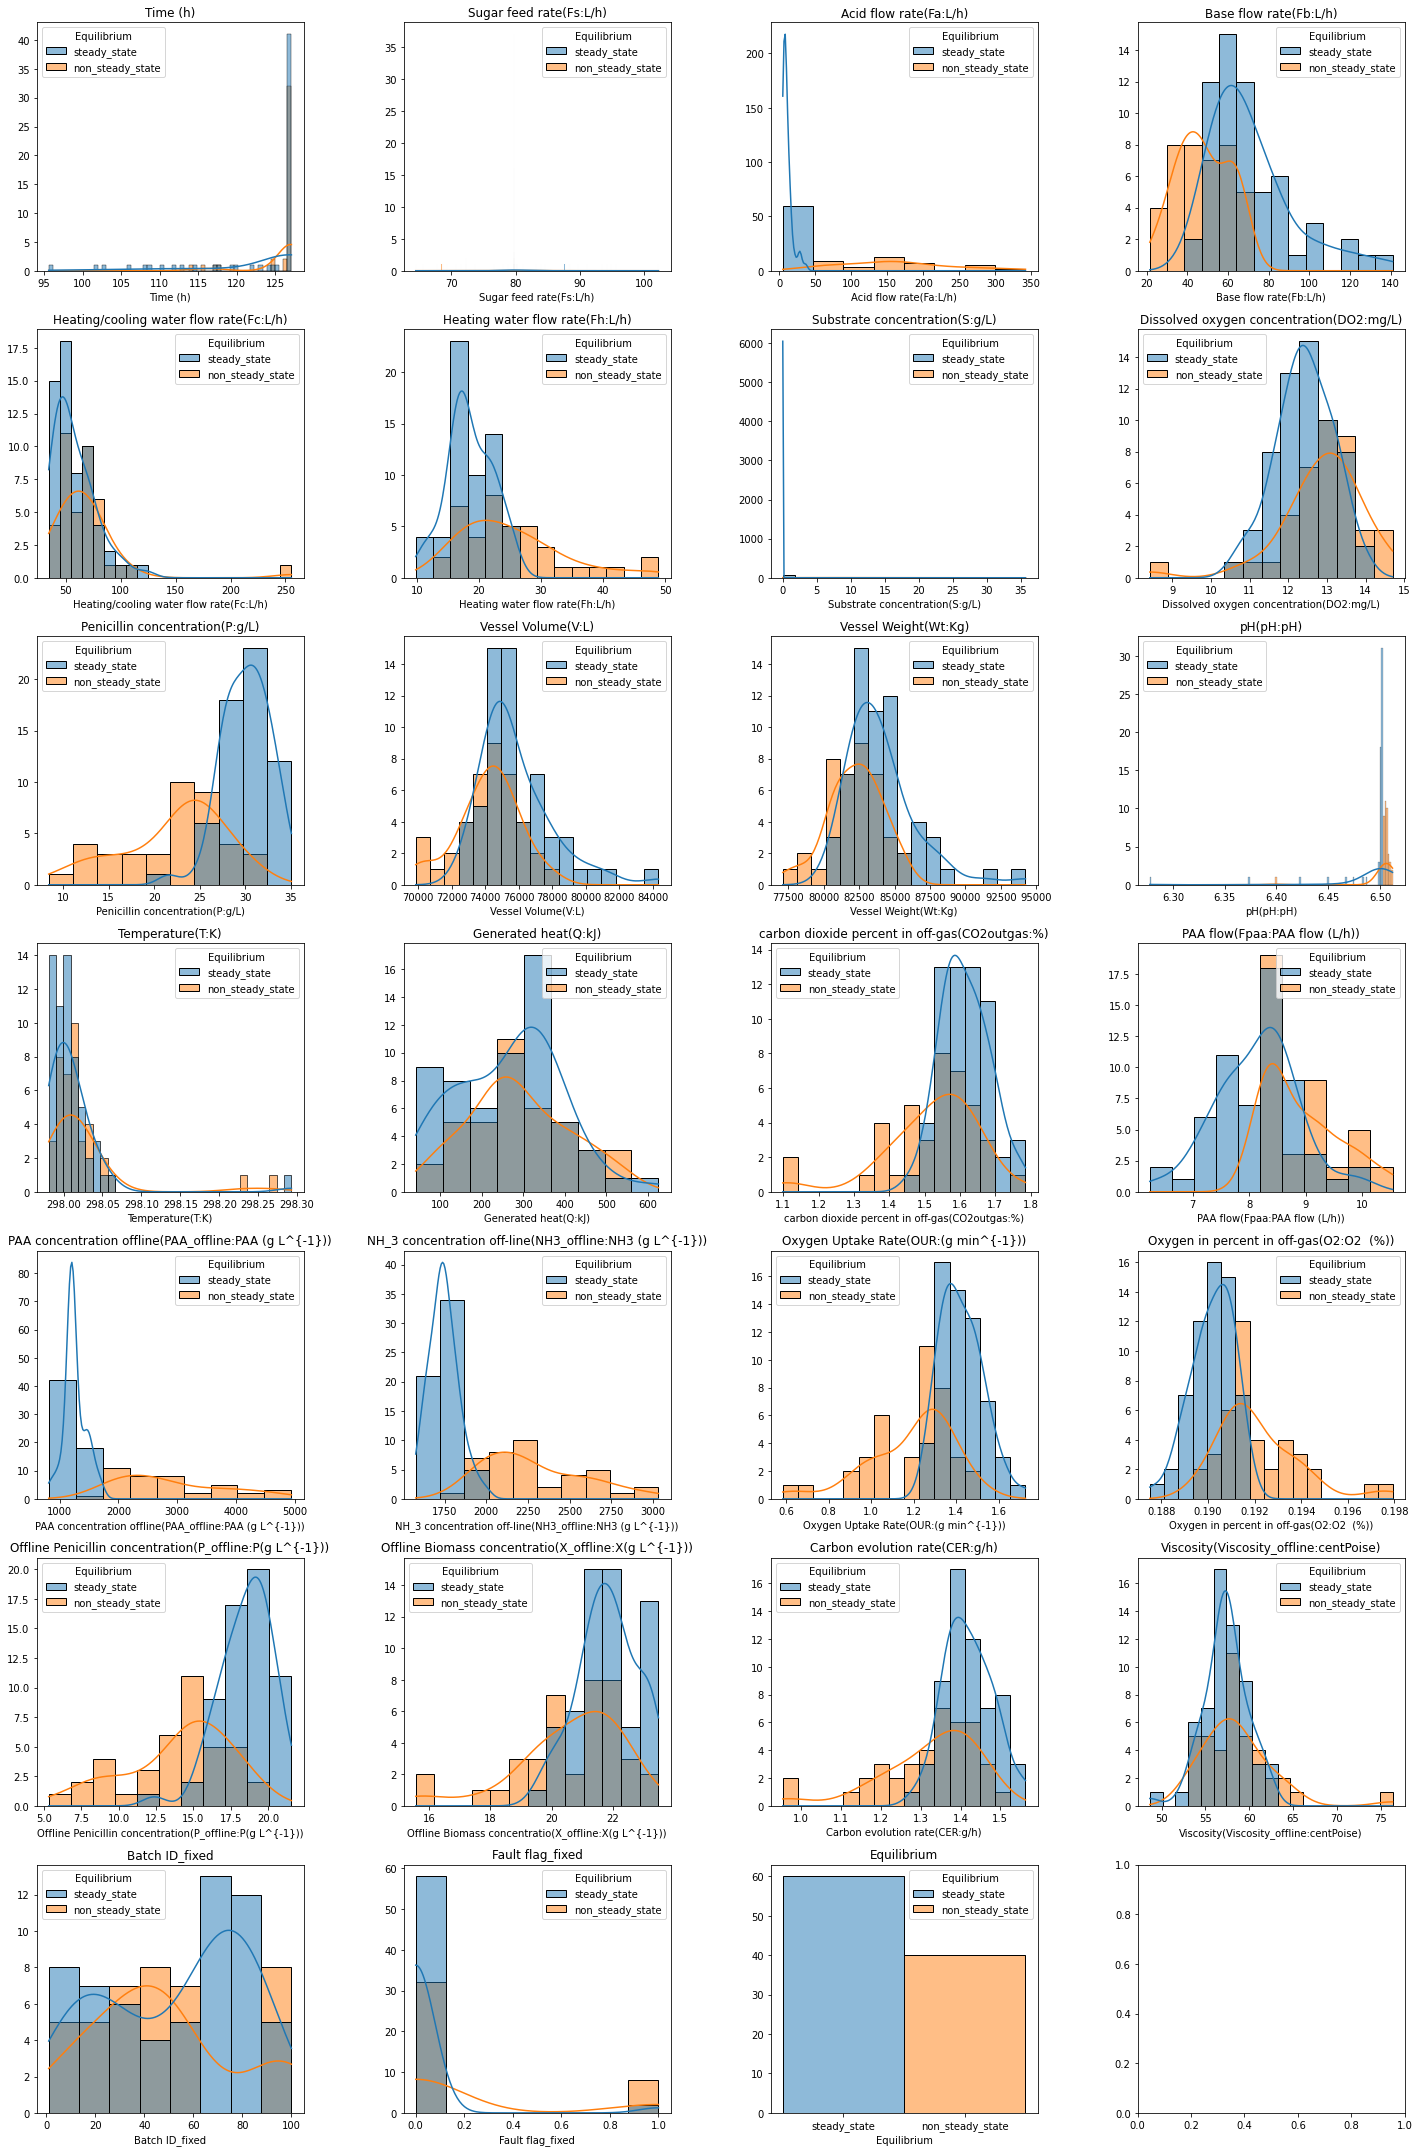

In [259]:
# Lets take a look at how each variable behaves
df_steady_fe['Equilibrium'] = 'steady_state'
df_non_steady_fe['Equilibrium'] = 'non_steady_state'
master_data_fe = pd.DataFrame()
master_data_fe = master_data_fe.append(df_steady_fe)
master_data_fe = master_data_fe.append(df_non_steady_fe)
master_data_fe = master_data_fe.reset_index(drop = True)

fig, ax = plt.subplots(7,4,figsize=(20,30))

for col, ax in zip(master_data_fe.columns, ax.flatten()):
    sns.histplot(x = col, data = master_data_fe, hue = 'Equilibrium', ax = ax, kde = True)
    ax.title.set_text(col)
    ax.set_ylabel('')
plt.tight_layout()
plt.show()


In [260]:
# Perform hypothesis testing for each variable
temp = master_data_fe
for col in temp.columns[1:-3]:
    steady_group = temp[temp['Equilibrium'] == 'steady_state'][col].tolist()
    non_steady_group = temp[temp['Equilibrium'] == 'non_steady_state'][col].tolist()
    statistical_sig = sp.stats.f_oneway(steady_group, non_steady_group)
    print(f"for {col}, ")
    if statistical_sig[1] < 0.04:
        print("we reject the null hypothesis, there is a clear difference in this variable between steady/nonsteady state", statistical_sig)
        print("")
    else:
        print("fail to reject", statistical_sig)
        print("")


for Sugar feed rate(Fs:L/h), 
we reject the null hypothesis, there is a clear difference in this variable between steady/nonsteady state F_onewayResult(statistic=10.777043740215127, pvalue=0.001425091898900389)

for Acid flow rate(Fa:L/h), 
we reject the null hypothesis, there is a clear difference in this variable between steady/nonsteady state F_onewayResult(statistic=226.1315925841935, pvalue=3.359444846452073e-27)

for Base flow rate(Fb:L/h), 
we reject the null hypothesis, there is a clear difference in this variable between steady/nonsteady state F_onewayResult(statistic=39.66843944862003, pvalue=8.55971355340752e-09)

for Heating/cooling water flow rate(Fc:L/h), 
fail to reject F_onewayResult(statistic=3.5185340252691026, pvalue=0.06366255474607119)

for Heating water flow rate(Fh:L/h), 
we reject the null hypothesis, there is a clear difference in this variable between steady/nonsteady state F_onewayResult(statistic=29.75212429610407, pvalue=3.6845199584766243e-07)

for Substra

Lots of observation can be made:

out of many hyp testing, three failed to be rejected: 

1. Heating/cooling water flow rate(Fc:L/h)
2. Temperature
3. Generated heat(Q:kJ)
4. pH(pH:pH)
5. Viscosity(Viscosity_offline:centPoise)

This means that those three are also not really helpful feature on distinguising the steady/non-steady rate.

From the histogram plots above, some important insights that I can make:

1. Penicillin concentration can reach its maximum when the process reaches a steady state. This is a very important observation, because any variable condition that is in the steady state can be deduced that those conditions are the conditions where generally we can maximize the penicilin production.

2. Acid flow rate: lower usage of the acid flow ensures the batch to reach the steady state. higher usage of acid flow shots generally contributes the whole batch evolution system to be in non-steady state

3. Base flow rate: steady 50 - 80 L/h flow is the optimal condition to reach steady state. Non-steady state demonstrates bimodal behavior on this variable, but on average, if the base flow rate is low, it cannot reach steady state

4. Dissolved oxygen concentration(DO2:mg/L): maintaining 12 - 13 has higher probability to reach steady state

5. carbon dioxide percent in off-gas(CO2outgas: %): if the CO2 percent in purge gas has lower CO2%, then it is likely that the batch did not reach steady state.

6. PAA concentration offline: lower PAA observed, steady state reached

7. NH3 concentration offline: similar observation as PAA

8. Oxygen Uptake Rate: lower OUR can lead to breakdown of steady state and going into non-steady state

9. Oxygen in percent off-gas: higher O2 in purge gas can lead to failure to reach steady state

and many more... but I will stop here for now.


## 3.5 Confounding/Alias

There are two reasons on why I am performing the confoundings analysis. 

1. Avoid misinterpretation of the predictor variable relationship that may impact to the final recommendation

2. If one ever try to model out the target variable using these predictors, the final performance metric of a selected model may not be fully impacted. but if the Idea is to put this model in production, any unforseen change in variable min-max range can lead to failure in predicting with the targeted performance metric (such as R2 or Accuracy or etc, depending on the selected model)

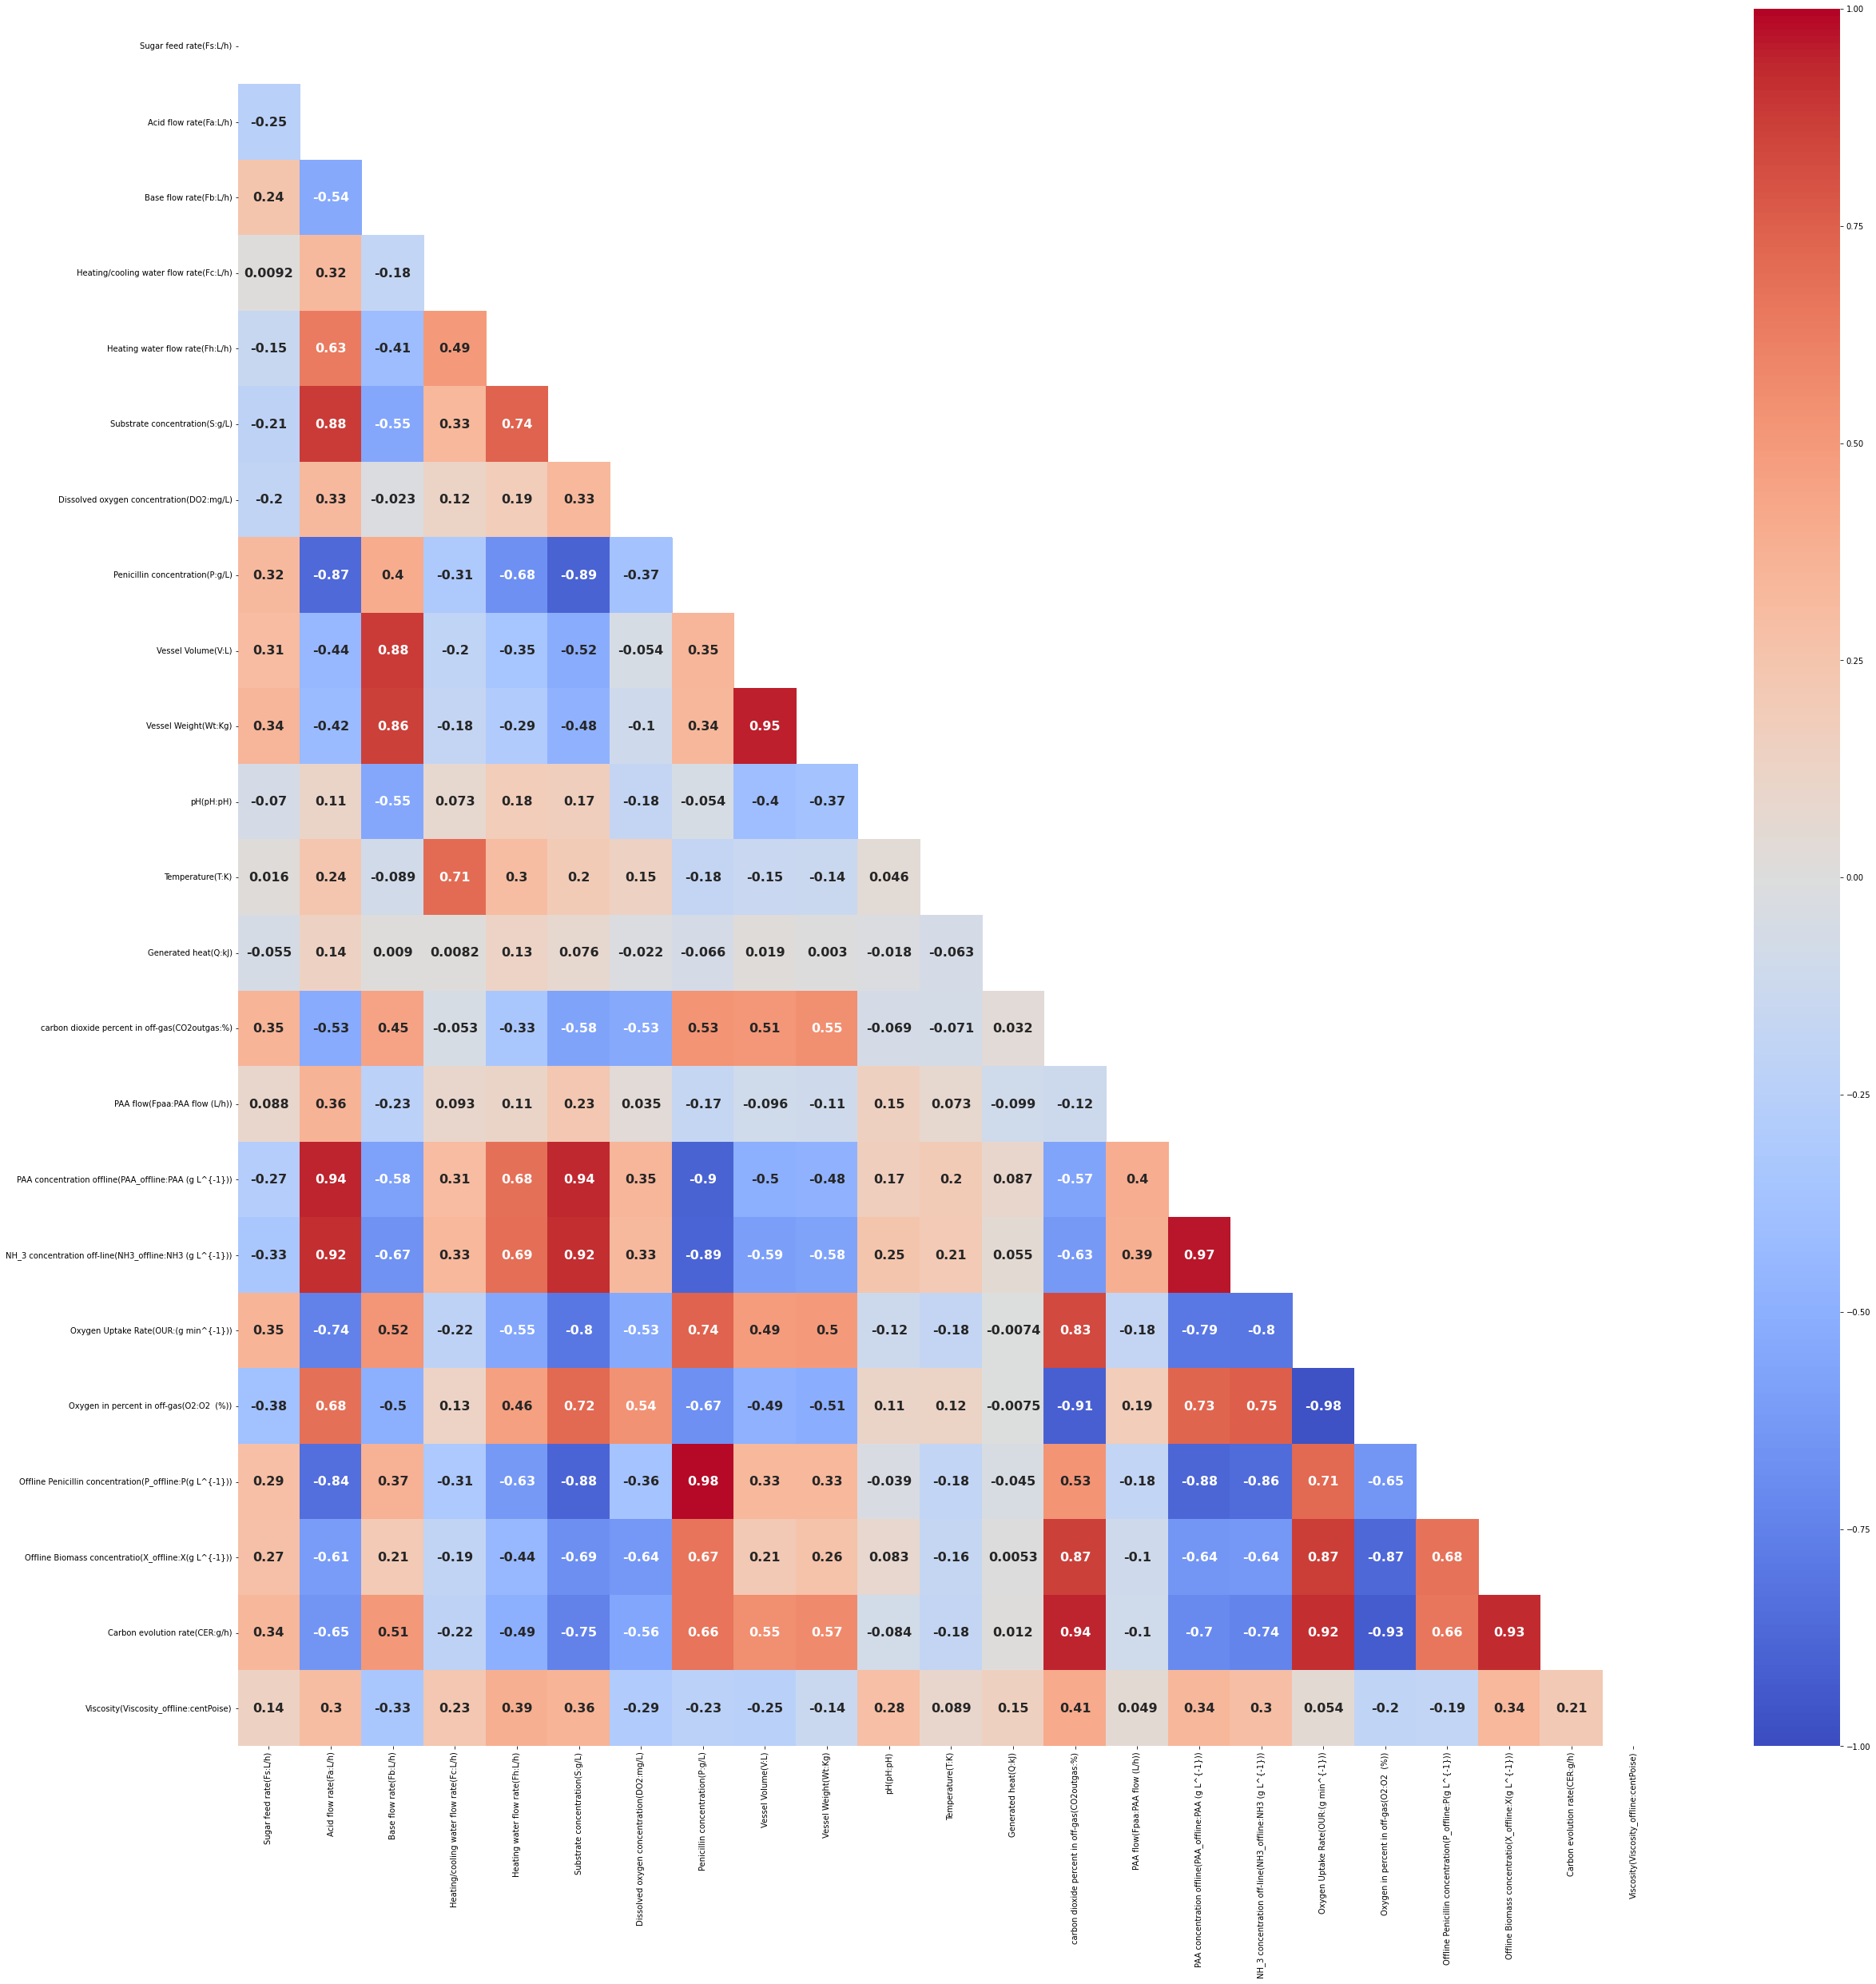

In [261]:
temp = master_data_fe.iloc[:,1:-3]
plt.figure(figsize = (40, 40))
mask = np.triu(temp.corr())
sns.heatmap(temp.corr(), 
            cmap = 'coolwarm', 
            center = 0, 
            vmin = -1, 
            vmax = 1, 
            annot = True, 
            mask = mask,
            annot_kws={
                'fontsize': 16,
                'fontweight': 'bold'
            }
)

Lets get this into a simpler format

In [262]:
# Unstack all the pearson Rs
corr_list = temp.corr().abs().unstack().sort_values(kind='quicksort').iloc[::-1]
corr_list = corr_list.reset_index()
corr_list.rename(columns={'level_0':'var_1','level_1':'var_2',0:'pearson R'},inplace=True)
corr_list.drop_duplicates(['pearson R'],inplace=True)
corr_list = corr_list[corr_list['var_1'] != corr_list['var_2']].reset_index(drop = True)

# select that demonstrates > 0.8 R
corr_list = corr_list[corr_list['pearson R'] > 0.8]
# check
corr_list

var_1  \
0                     Penicillin concentration(P:g/L)   
1            Oxygen in percent in off-gas(O2:O2  (%))   
2   NH_3 concentration off-line(NH3_offline:NH3 (g...   
3                                Vessel Weight(Wt:Kg)   
4   PAA concentration offline(PAA_offline:PAA (g L...   
5                      Carbon evolution rate(CER:g/h)   
6                      Substrate concentration(S:g/L)   
7                      Carbon evolution rate(CER:g/h)   
8            Oxygen in percent in off-gas(O2:O2  (%))   
9                      Carbon evolution rate(CER:g/h)   
10  NH_3 concentration off-line(NH3_offline:NH3 (g...   
11                     Substrate concentration(S:g/L)   
12     carbon dioxide percent in off-gas(CO2outgas:%)   
13  PAA concentration offline(PAA_offline:PAA (g L...   
14                     Substrate concentration(S:g/L)   
15  NH_3 concentration off-line(NH3_offline:NH3 (g...   
16  Offline Penicillin concentration(P_offline:P(g...   
17                     Substrate concentration(S:g/L)   
18                                 Vessel Volume(V:L)   
19  Offline Penicillin concentration(P_offline:P(g...   
20           Oxygen in percent in off-gas(O2:O2  (%))   
21               Oxygen Uptake Rate(OUR:(g min^{-1}))   
22     carbon dioxide percent in off-gas(CO2outgas:%)   
23                             Acid flow rate(Fa:L/h)   
24                               Vessel Weight(Wt:Kg)   
25  NH_3 concentration off-line(NH3_offline:NH3 (g...   
26                             Acid flow rate(Fa:L/h)   
27     carbon dioxide percent in off-gas(CO2outgas:%)   
28               Oxygen Uptake Rate(OUR:(g min^{-1}))   
29               Oxygen Uptake Rate(OUR:(g min^{-1}))   

                                                var_2  pearson R  
0   Offline Penicillin concentration(P_offline:P(g...   0.984546  
1                Oxygen Uptake Rate(OUR:(g min^{-1}))   0.975354  
2   PAA concentration offline(PAA_offline:PAA (g L...   0.965797  
3                                  Vessel Volume(V:L)   0.951424  
4                              Acid flow rate(Fa:L/h)   0.941825  
5      carbon dioxide percent in off-gas(CO2outgas:%)   0.939840  
6   PAA concentration offline(PAA_offline:PAA (g L...   0.936708  
7   Offline Biomass concentratio(X_offline:X(g L^{...   0.927796  
8                      Carbon evolution rate(CER:g/h)   0.927768  
9                Oxygen Uptake Rate(OUR:(g min^{-1}))   0.920230  
10                             Acid flow rate(Fa:L/h)   0.917150  
11  NH_3 concentration off-line(NH3_offline:NH3 (g...   0.915535  
12           Oxygen in percent in off-gas(O2:O2  (%))   0.913914  
13                    Penicillin concentration(P:g/L)   0.898041  
14                    Penicillin concentration(P:g/L)   0.893887  
15                    Penicillin concentration(P:g/L)   0.887796  
16                     Substrate concentration(S:g/L)   0.883196  
17                             Acid flow rate(Fa:L/h)   0.880863  
18                             Base flow rate(Fb:L/h)   0.879408  
19  PAA concentration offline(PAA_offline:PAA (g L...   0.877024  
20  Offline Biomass concentratio(X_offline:X(g L^{...   0.869946  
21  Offline Biomass concentratio(X_offline:X(g L^{...   0.867594  
22  Offline Biomass concentratio(X_offline:X(g L^{...   0.866488  
23                    Penicillin concentration(P:g/L)   0.865458  
24                             Base flow rate(Fb:L/h)   0.860334  
25  Offline Penicillin concentration(P_offline:P(g...   0.858443  
26  Offline Penicillin concentration(P_offline:P(g...   0.842766  
27               Oxygen Uptake Rate(OUR:(g min^{-1}))   0.832200  
28  NH_3 concentration off-line(NH3_offline:NH3 (g...   0.802948  
29                     Substrate concentration(S:g/L)   0.801976

So, all these combinations, except for our target penicillin concentration, have danger of getting misinterpreted. To determine which variable to select, feedback from the domain expert is the best way; however, to do this numerically, out of the confounded variable, we would select the variables that exhibits better correlation with the target variable.

## 3.6 Classifications of target variables

We now have partitioned our data into 2: steady state / non-steady state. 

Since our objective is to study the condition that produces the highest yield of penicillion concentration, we will deep dive into the steady state datasets

First of all, what is our maximum penecilin concentration? which batch? -> batch 48

In [263]:
max_penicilin = max(df_steady['Penicillin concentration(P:g/L)'])
df_steady_fe[df_steady_fe['Penicillin concentration(P:g/L)'] == max_penicilin]

Time (h)  Sugar feed rate(Fs:L/h)  Acid flow rate(Fa:L/h)  \
24     127.1                94.864078                15.58495   

    Base flow rate(Fb:L/h)  Heating/cooling water flow rate(Fc:L/h)  \
24               86.669679                                68.651388   

    Heating water flow rate(Fh:L/h)  Substrate concentration(S:g/L)  \
24                        15.947871                        0.005711   

    Dissolved oxygen concentration(DO2:mg/L)  Penicillin concentration(P:g/L)  \
24                                 12.172281                           35.088   

    Vessel Volume(V:L)  Vessel Weight(Wt:Kg)  pH(pH:pH)  Temperature(T:K)  \
24         76763.28835          85021.307767   6.501758           298.014   

    Generated heat(Q:kJ)  carbon dioxide percent in off-gas(CO2outgas:%)  \
24            195.184864                                         1.75099   

    PAA flow(Fpaa:PAA flow (L/h))  \
24                      10.049515   

    PAA concentration offline(PAA_offline:PAA (g L^{-1}))  \
24                                        1438.652778       

    NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))  \
24                                        1689.583333         

    Oxygen Uptake Rate(OUR:(g min^{-1}))  \
24                              1.636173   

    Oxygen in percent in off-gas(O2:O2  (%))  \
24                                  0.188179   

    Offline Penicillin concentration(P_offline:P(g L^{-1}))  \
24                                          21.521461         

    Offline Biomass concentratio(X_offline:X(g L^{-1}))  \
24                                          23.483611     

    Carbon evolution rate(CER:g/h)  Viscosity(Viscosity_offline:centPoise)  \
24                        1.541262                               62.014111   

    Batch ID_fixed  Fault flag_fixed   Equilibrium  
24            48.0               0.0  steady_state

We would also like to see that out of all the steady state, which combination of the variable at which range produces the best results. for this, I will group the data into 3, and plot the histogram only for first and last group, to see their vivid change.

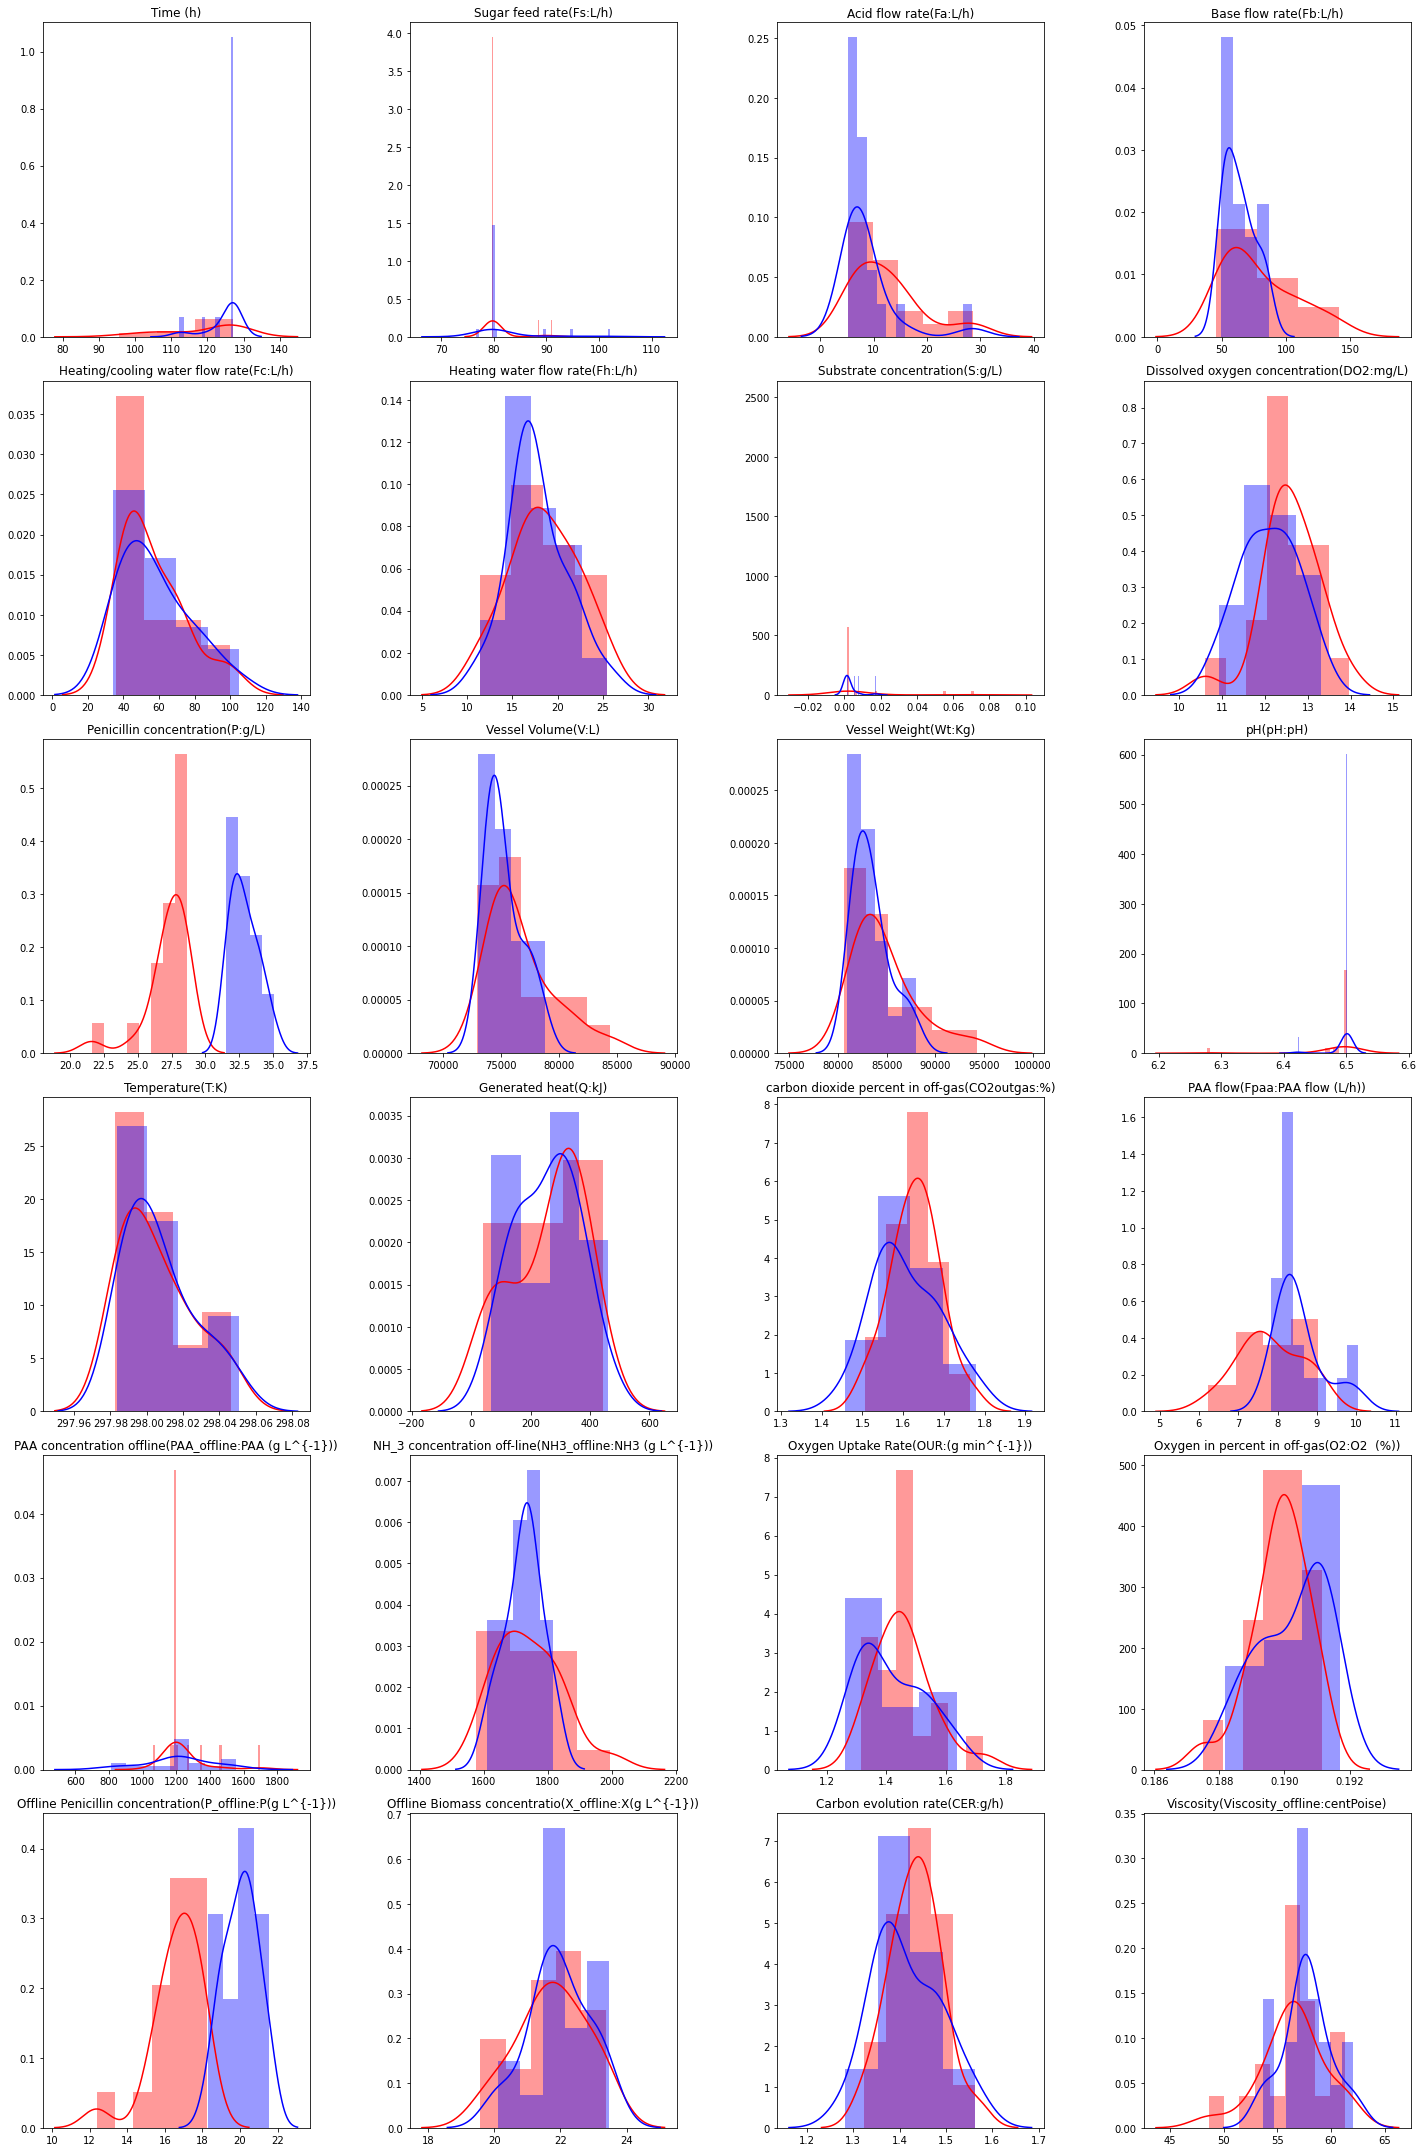

In [268]:
tempList = pd.qcut(df_steady_fe['Penicillin concentration(P:g/L)'],3)
tempList = list(map(str, tempList))
tempList2 = []
for i in tempList:
    if i == "(21.595, 28.716]":
        tempList2.append(0)
    elif i == "(28.716, 31.471]":
        tempList2.append(1)
    else:
        tempList2.append(2)

df_steady_fe["quantiled"] = pd.Series(tempList2)

df_steady_grp1 = df_steady_fe[df_steady_fe['quantiled'] == 0]
df_steady_grp2 = df_steady_fe[df_steady_fe['quantiled'] == 1]
df_steady_grp3 = df_steady_fe[df_steady_fe['quantiled'] == 2]

fig, ax = plt.subplots(6,4,figsize=(20,30))

for col, ax in zip(df_steady_fe.columns[:-4], ax.flatten()):
    sns.distplot(x = df_steady_grp1[col], ax = ax, kde = True, color = "red")
    # sns.distplot(x = df_steady_grp2[col], ax = ax, kde = True, color = "green")
    sns.distplot(x = df_steady_grp3[col], ax = ax, kde = True, color = "blue")
    ax.title.set_text(col)
    ax.set_ylabel('')
plt.tight_layout()
plt.show()

So what I can say about these three group comparison is that only few variable demonstrates some difference of all three groups.

general remarks of these three groups was that the group 1 and 2 (which is low and medium, denoted as red and green) generation rate of penicillin was showing similar profile among variables, where the different starts to show in group 3.

To ensure good quality after reaching steady state condition,

 1. 'Acid flow rate(Fa:L/h)',
> the best group of batches that demonstrated highest yield of penincillin achieved consistent and maintained its low acid flow usage during total sum of each batch run.

 2. 'Base flow rate(Fb:L/h)',
> Along with the acid flow rate, consistent and minimum usage of base flow rate maintained at around 50 - 60 L/h demonstrated best result.

 3. 'Heating water flow rate(Fh:L/h)',
> Group 3, best candidates were using relatively lower heating water flow rate than other group 1 or 2 batches.

 4. 'Dissolved oxygen concentration(DO2:mg/L)',
> maintaining lower than 13 mg/L was showing the best result (group 3). when the dissolved oxygen concentration was high, the results were not so good.

 5. 'carbon dioxide percent in off-gas(CO2outgas:%)',
> Group 3 demonstrated lower CO2outgas% than any other groups

 6. 'PAA flow(Fpaa:PAA flow (L/h))',
> Consistent maintenance in a range of 8 - 9 L/h was showing the best results. Group 1, which has its mode at 7-8, was not showing good results in penicillin generation.

 7. 'NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))',
> consistent average of 1700 - 1800 flow recommended according to the group 3 response.

 8. 'Oxygen Uptake Rate(OUR:(g min^{-1}))',
> confounded with Oxygen in percent in off-gas, higher OUR was observed in group 3

 9. 'Oxygen in percent in off-gas(O2:O2  (%))',
> confounded with OUR, lower Oxygen in percent off-gas was observed in group 3

 10. 'Carbon evolution rate(CER:g/h)',
> maintaining lower carbon evolution rate was good for penicillin generation as it was observed in group 3

 11. 'Viscosity(Viscosity_offline:centPoise)',
> maintaining consistent 58 cP was showing best result.

Following plot is variable behavior for each batch run, and the best result, which is batch 48 is denoted as red. 

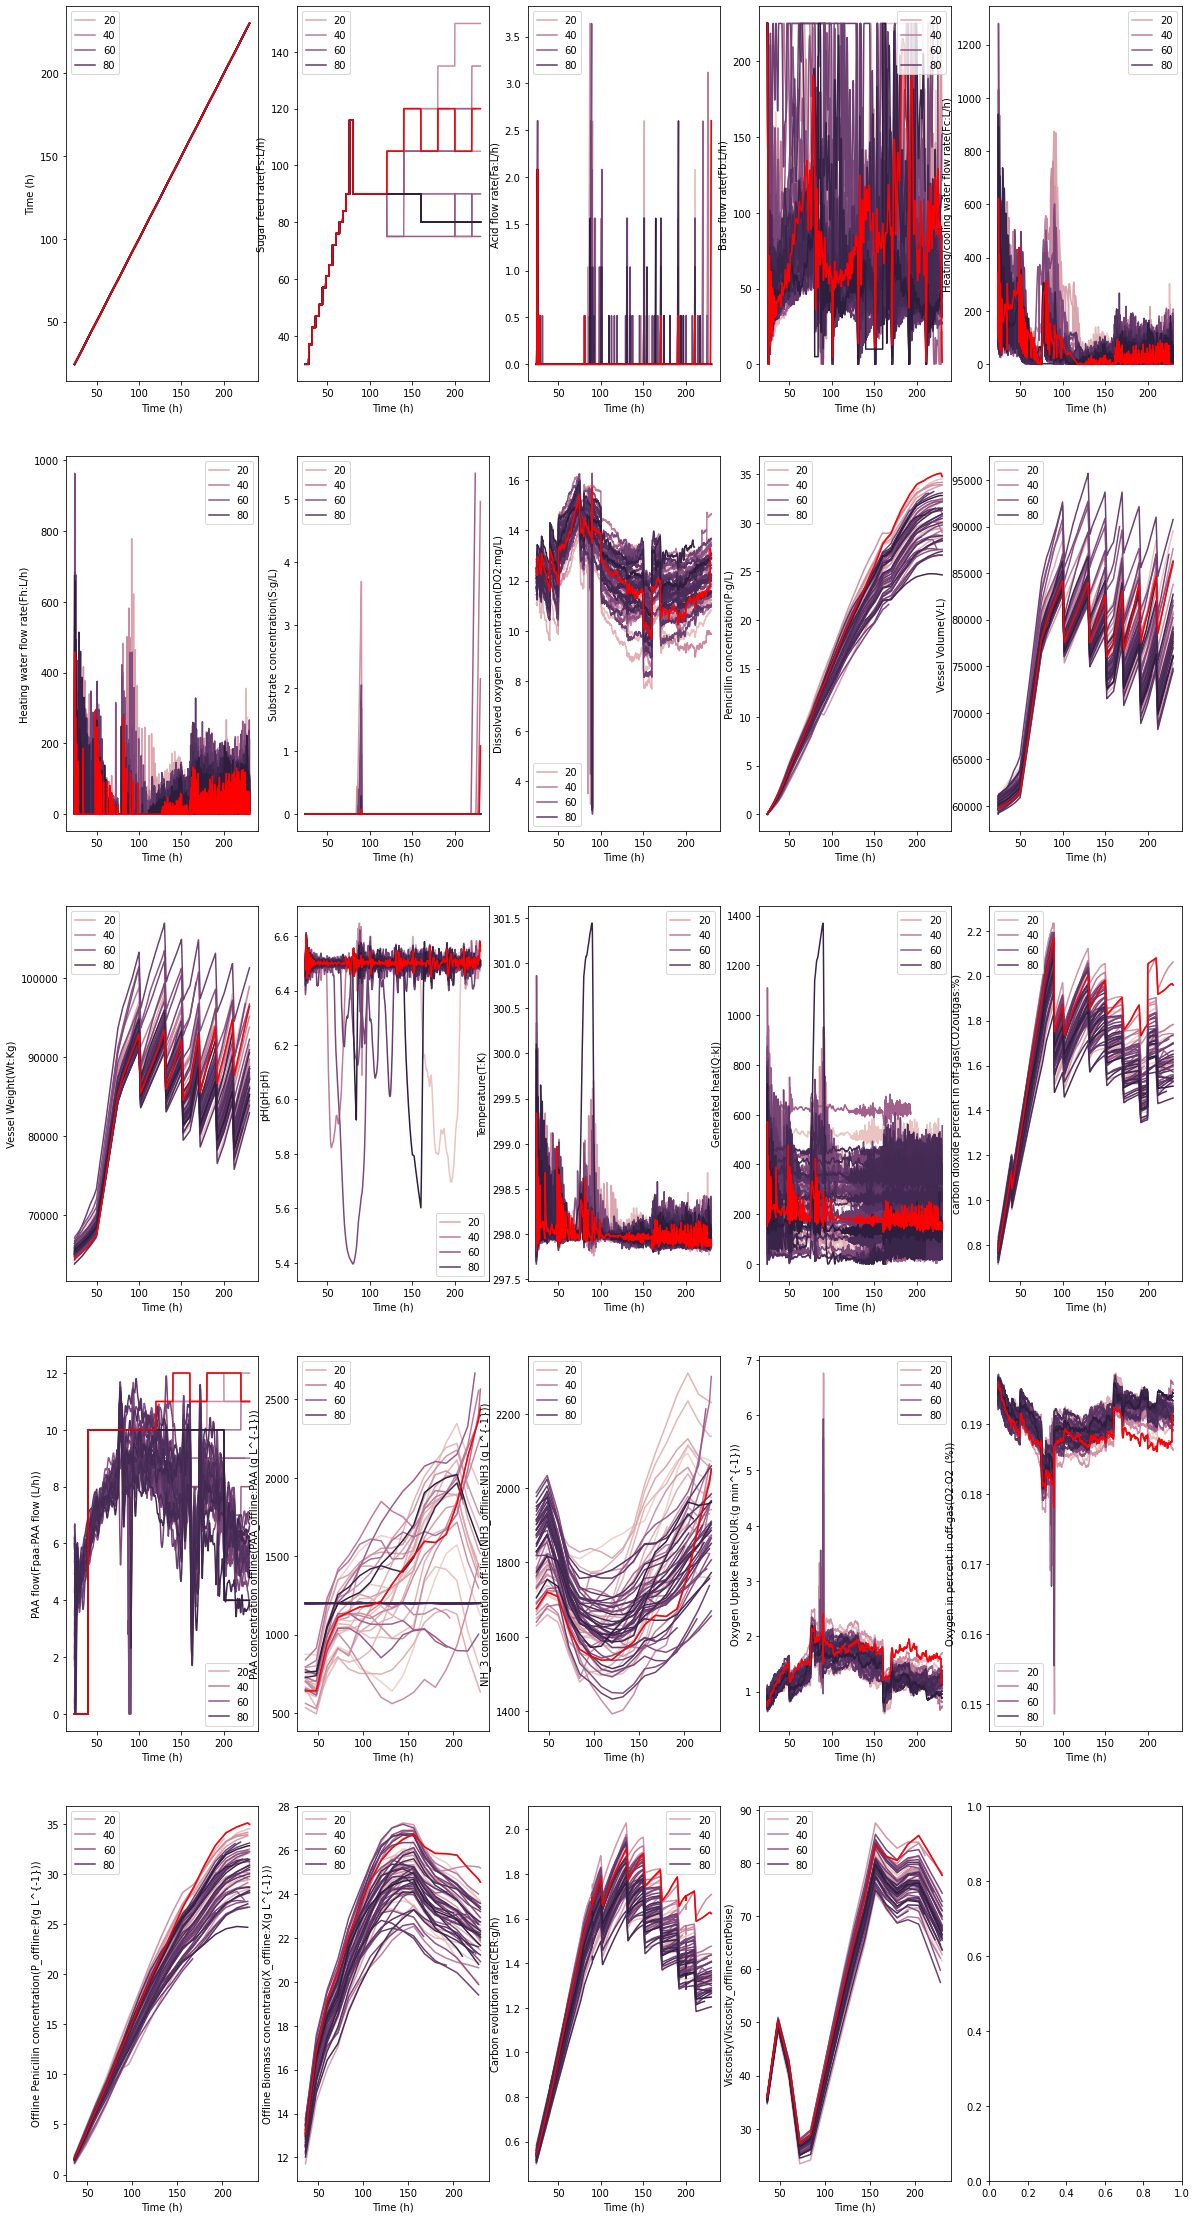

In [241]:
fig, ax = plt.subplots(5,5,figsize = (20,40))

for col, ax in zip(df_steady.columns[:-2], ax.flatten()):
    sns.lineplot(x = df_steady['Time (h)'], y = col, hue = 'Batch ID_fixed', data = df_steady, ax = ax)
    sns.lineplot(x = df_steady['Time (h)'], y = col, data = df_steady[df_steady['Batch ID_fixed'] == 48], ax = ax, color = 'red')

## 3.7 PCA enabled K-means clustering (validation)

As an extra, lets apply k means clustering to validate our findings. Technically saying, when we try to use the BLM approach, we need to implement a concept of Batchwise Unfolding, which makes every regular interval snapshots into columns for every variable and use the PCA for dimensionality reduction. but for simplicity, let us try on what I have done so far (just use the aggregation to represent the final condition of each batch runs) and see if I get the similar result

In [301]:
# k means clustering of the optimal data
temp = master_data_fe.iloc[:,:-3]
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(temp)
pca = PCA()
pca.fit(temp)
pca.explained_variance_ratio_

array([9.10427241e-01, 6.61387112e-02, 2.15850440e-02, 1.28596536e-03,
       4.24836727e-04, 7.05611335e-05, 5.19114444e-05, 7.96792691e-06,
       2.78057769e-06, 2.14121016e-06, 1.53230735e-06, 5.92995041e-07,
       4.08578194e-07, 2.24928835e-07, 4.59162987e-08, 1.60058403e-08,
       9.33194305e-09, 8.80809421e-09, 2.42964684e-10, 8.38062877e-11,
       3.94731047e-11, 3.56857724e-11, 8.54454433e-13, 1.06541701e-16])

Text(0, 0.5, 'Cumulative Explained Variance')

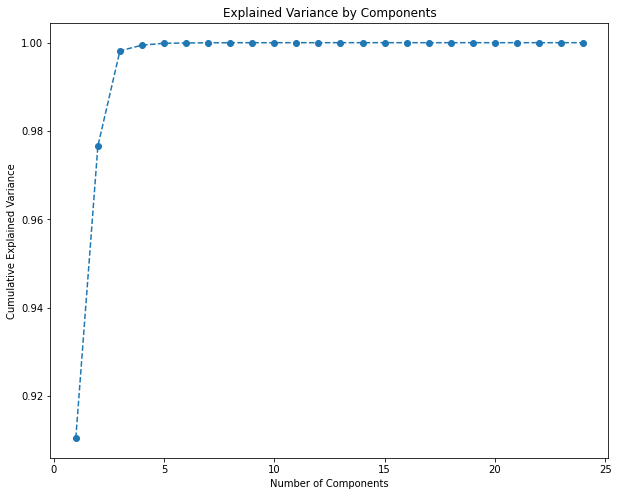

In [303]:
plt.figure(figsize=(10,8))
plt.plot(range(1,25) , pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [304]:
pca = PCA(n_components=3)
pca.fit(temp)

PCA(n_components=3)

In [305]:
pca.transform(segmentation_std)
scores_pca = pca.transform(segmentation_std)
pd.DataFrame(pca.components_,columns=temp.columns)

Time (h)  Sugar feed rate(Fs:L/h)  Acid flow rate(Fa:L/h)  \
0 -0.000310                 0.000592               -0.012835   
1  0.001123                -0.000690                0.081611   
2  0.002745                 0.001368               -0.005386   

   Base flow rate(Fb:L/h)  Heating/cooling water flow rate(Fc:L/h)  \
0                0.005726                                -0.001640   
1               -0.003188                                 0.007287   
2               -0.002414                                 0.002406   

   Heating water flow rate(Fh:L/h)  Substrate concentration(S:g/L)  \
0                        -0.000720                       -0.001165   
1                         0.004577                        0.006126   
2                         0.001445                        0.000445   

   Dissolved oxygen concentration(DO2:mg/L)  Penicillin concentration(P:g/L)  \
0                                 -0.000028                         0.000663   
1                                  0.000355                        -0.005214   
2                                 -0.000361                         0.000902   

   Vessel Volume(V:L)  Vessel Weight(Wt:Kg)  pH(pH:pH)  Temperature(T:K)  \
0            0.657755              0.732923  -0.000004     -2.188198e-06   
1            0.065452              0.173239  -0.000001      7.602169e-06   
2           -0.750151              0.657753   0.000006      3.004854e-07   

   Generated heat(Q:kJ)  carbon dioxide percent in off-gas(CO2outgas:%)  \
0              0.000200                                        0.000019   
1              0.014654                                       -0.000039   
2             -0.016532                                        0.000036   

   PAA flow(Fpaa:PAA flow (L/h))  \
0                      -0.000030   
1                       0.000350   
2                      -0.000121   

   PAA concentration offline(PAA_offline:PAA (g L^{-1}))  \
0                                          -0.161159       
1                                           0.938125       
2                                          -0.063340       

   NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))  \
0                                          -0.063294         
1                                           0.280336         
2                                          -0.017043         

   Oxygen Uptake Rate(OUR:(g min^{-1}))  \
0                              0.000030   
1                             -0.000128   
2                              0.000029   

   Oxygen in percent in off-gas(O2:O2  (%))  \
0                             -2.647588e-07   
1                              9.648410e-07   
2                             -3.859162e-07   

   Offline Penicillin concentration(P_offline:P(g L^{-1}))  \
0                                           0.000385         
1                                          -0.003043         
2                                           0.000591         

   Offline Biomass concentratio(X_offline:X(g L^{-1}))  \
0                                           0.000119     
1                                          -0.000950     
2                                           0.000615     

   Carbon evolution rate(CER:g/h)  Viscosity(Viscosity_offline:centPoise)  
0                        0.000019                               -0.000207  
1                       -0.000053                                0.001067  
2                        0.000023                                0.002124

Text(0, 0.5, 'WCSS')

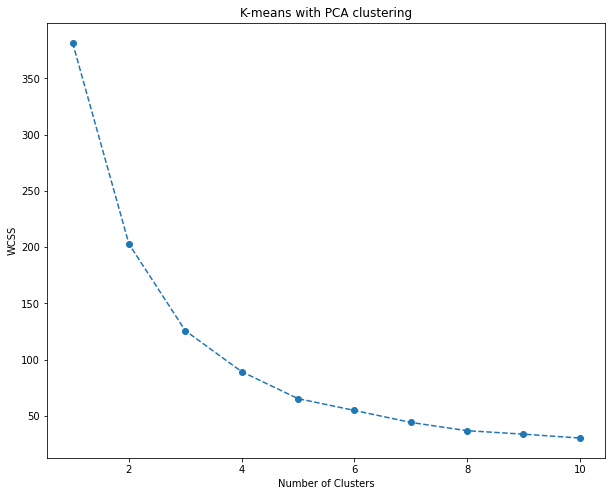

In [306]:
# Within-Cluster-Sum-of-Squares
wcss = []
for i in range(1,11):
  kmeans_pca = KMeans(n_clusters=i,init='k-means++',random_state=42)
  kmeans_pca.fit(scores_pca)
  wcss.append(kmeans_pca.inertia_)

plt.figure(figsize=(10,8))
plt.plot(range(1,11) , wcss, marker = 'o', linestyle = '--')
plt.title('K-means with PCA clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

In [307]:
# from the chart above, I would say elbow is around cluster 3 and after
# it seems major steepness (Within Cluster Sum Square) starts at Cluster 3. we keep first 3 clusters 
kmeans_pca = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=3, random_state=42)

In [308]:
df_with_pca_cluster = pd.concat([temp.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_with_pca_cluster.columns.values[-3:] = ['Component 1','Component 2','Component 3']
# df_with_pca_cluster.columns.values[-2:] = ['Component 1','Component 2']
df_with_pca_cluster['K Means Cluster #'] = kmeans_pca.labels_
df_with_pca_cluster.head()

Time (h)  Sugar feed rate(Fs:L/h)  Acid flow rate(Fa:L/h)  \
0     125.1                79.782178                 8.82466   
1     127.1                79.786408                 6.75667   
2     101.6                79.716129                 6.23118   
3     127.1                79.786408                12.97498   
4     127.1                79.786408                 7.26416   

   Base flow rate(Fb:L/h)  Heating/cooling water flow rate(Fc:L/h)  \
0               70.615029                                51.469853   
1               66.428532                                62.540281   
2               60.960926                                48.257091   
3              116.932756                                43.785356   
4               65.730578                                52.979384   

   Heating water flow rate(Fh:L/h)  Substrate concentration(S:g/L)  \
0                        12.810370                        0.001555   
1                        18.388045                        0.001388   
2                        11.377485                        0.001509   
3                        17.756618                        0.001387   
4                        17.856296                        0.001342   

   Dissolved oxygen concentration(DO2:mg/L)  Penicillin concentration(P:g/L)  \
0                                 12.419881                           29.409   
1                                 12.812119                           30.416   
2                                 12.016205                           28.172   
3                                 13.007973                           29.361   
4                                 10.920845                           34.508   

   Vessel Volume(V:L)  Vessel Weight(Wt:Kg)  pH(pH:pH)  Temperature(T:K)  \
0        74552.407921          82712.690099   6.501160        298.002030   
1        77109.026214          85181.644660   6.501526        298.003990   
2        74206.243871          82820.952258   6.501501        298.001239   
3        77849.144660          86305.253398   6.373556        297.984524   
4        76008.966019          84327.559223   6.501414        298.000340   

   Generated heat(Q:kJ)  carbon dioxide percent in off-gas(CO2outgas:%)  \
0             61.575279                                        1.599091   
1             90.729239                                        1.555618   
2             87.339476                                        1.637831   
3            520.975864                                        1.620476   
4            364.974107                                        1.694174   

   PAA flow(Fpaa:PAA flow (L/h))  \
0                       8.435644   
1                       8.349515   
2                       8.967742   
3                       8.349515   
4                       8.349515   

   PAA concentration offline(PAA_offline:PAA (g L^{-1}))  \
0                                        1507.756471       
1                                         986.419444       
2                                        1273.220000       
3                                        1447.144118       
4                                        1024.685556       

   NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))  \
0                                        1914.388235         
1                                        1785.011111         
2                                        1691.753846         
3                                        1683.652941         
4                                        1670.655556         

   Oxygen Uptake Rate(OUR:(g min^{-1}))  \
0                              1.401704   
1                              1.443244   
2                              1.573044   
3                              1.365894   
4                              1.620630   

   Oxygen in percent in off-gas(O2:O2  (%))  \
0                                  0.190498   
1                                  0.190121   
2                                  0

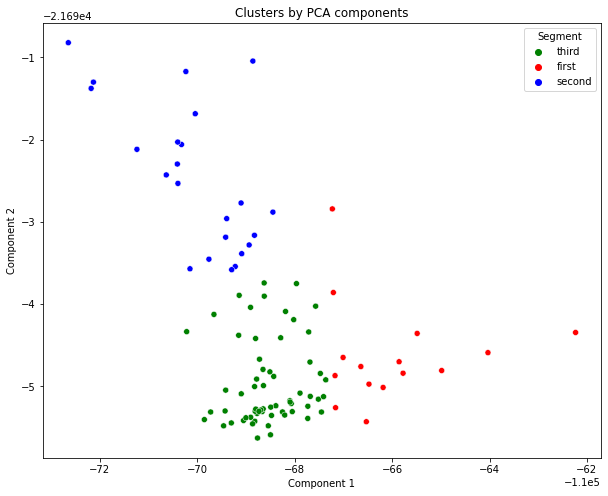

In [309]:
df_with_pca_cluster['Segment'] = df_with_pca_cluster['K Means Cluster #'].map({0:'first',1:'second',2:'third'})
# df_with_pca_cluster['Segment'] = df_with_pca_cluster['K Means Cluster #'].map({0:'first',1:'second'})
# PC1 vs PC2 - vary this to view 
x_axis = df_with_pca_cluster['Component 1']
y_axis = df_with_pca_cluster['Component 2']
plt.figure(figsize = (10,8))
sns.scatterplot(x_axis, y_axis, hue = df_with_pca_cluster['Segment'],palette= ['g','r','b'])
plt.title('Clusters by PCA components')
plt.show()

In [310]:
df_cluster = df_with_pca_cluster.set_index('Segment')

In [311]:
cluster_1 = df_cluster.loc['first']
cluster_2 = df_cluster.loc['second']
cluster_3 = df_cluster.loc['third']

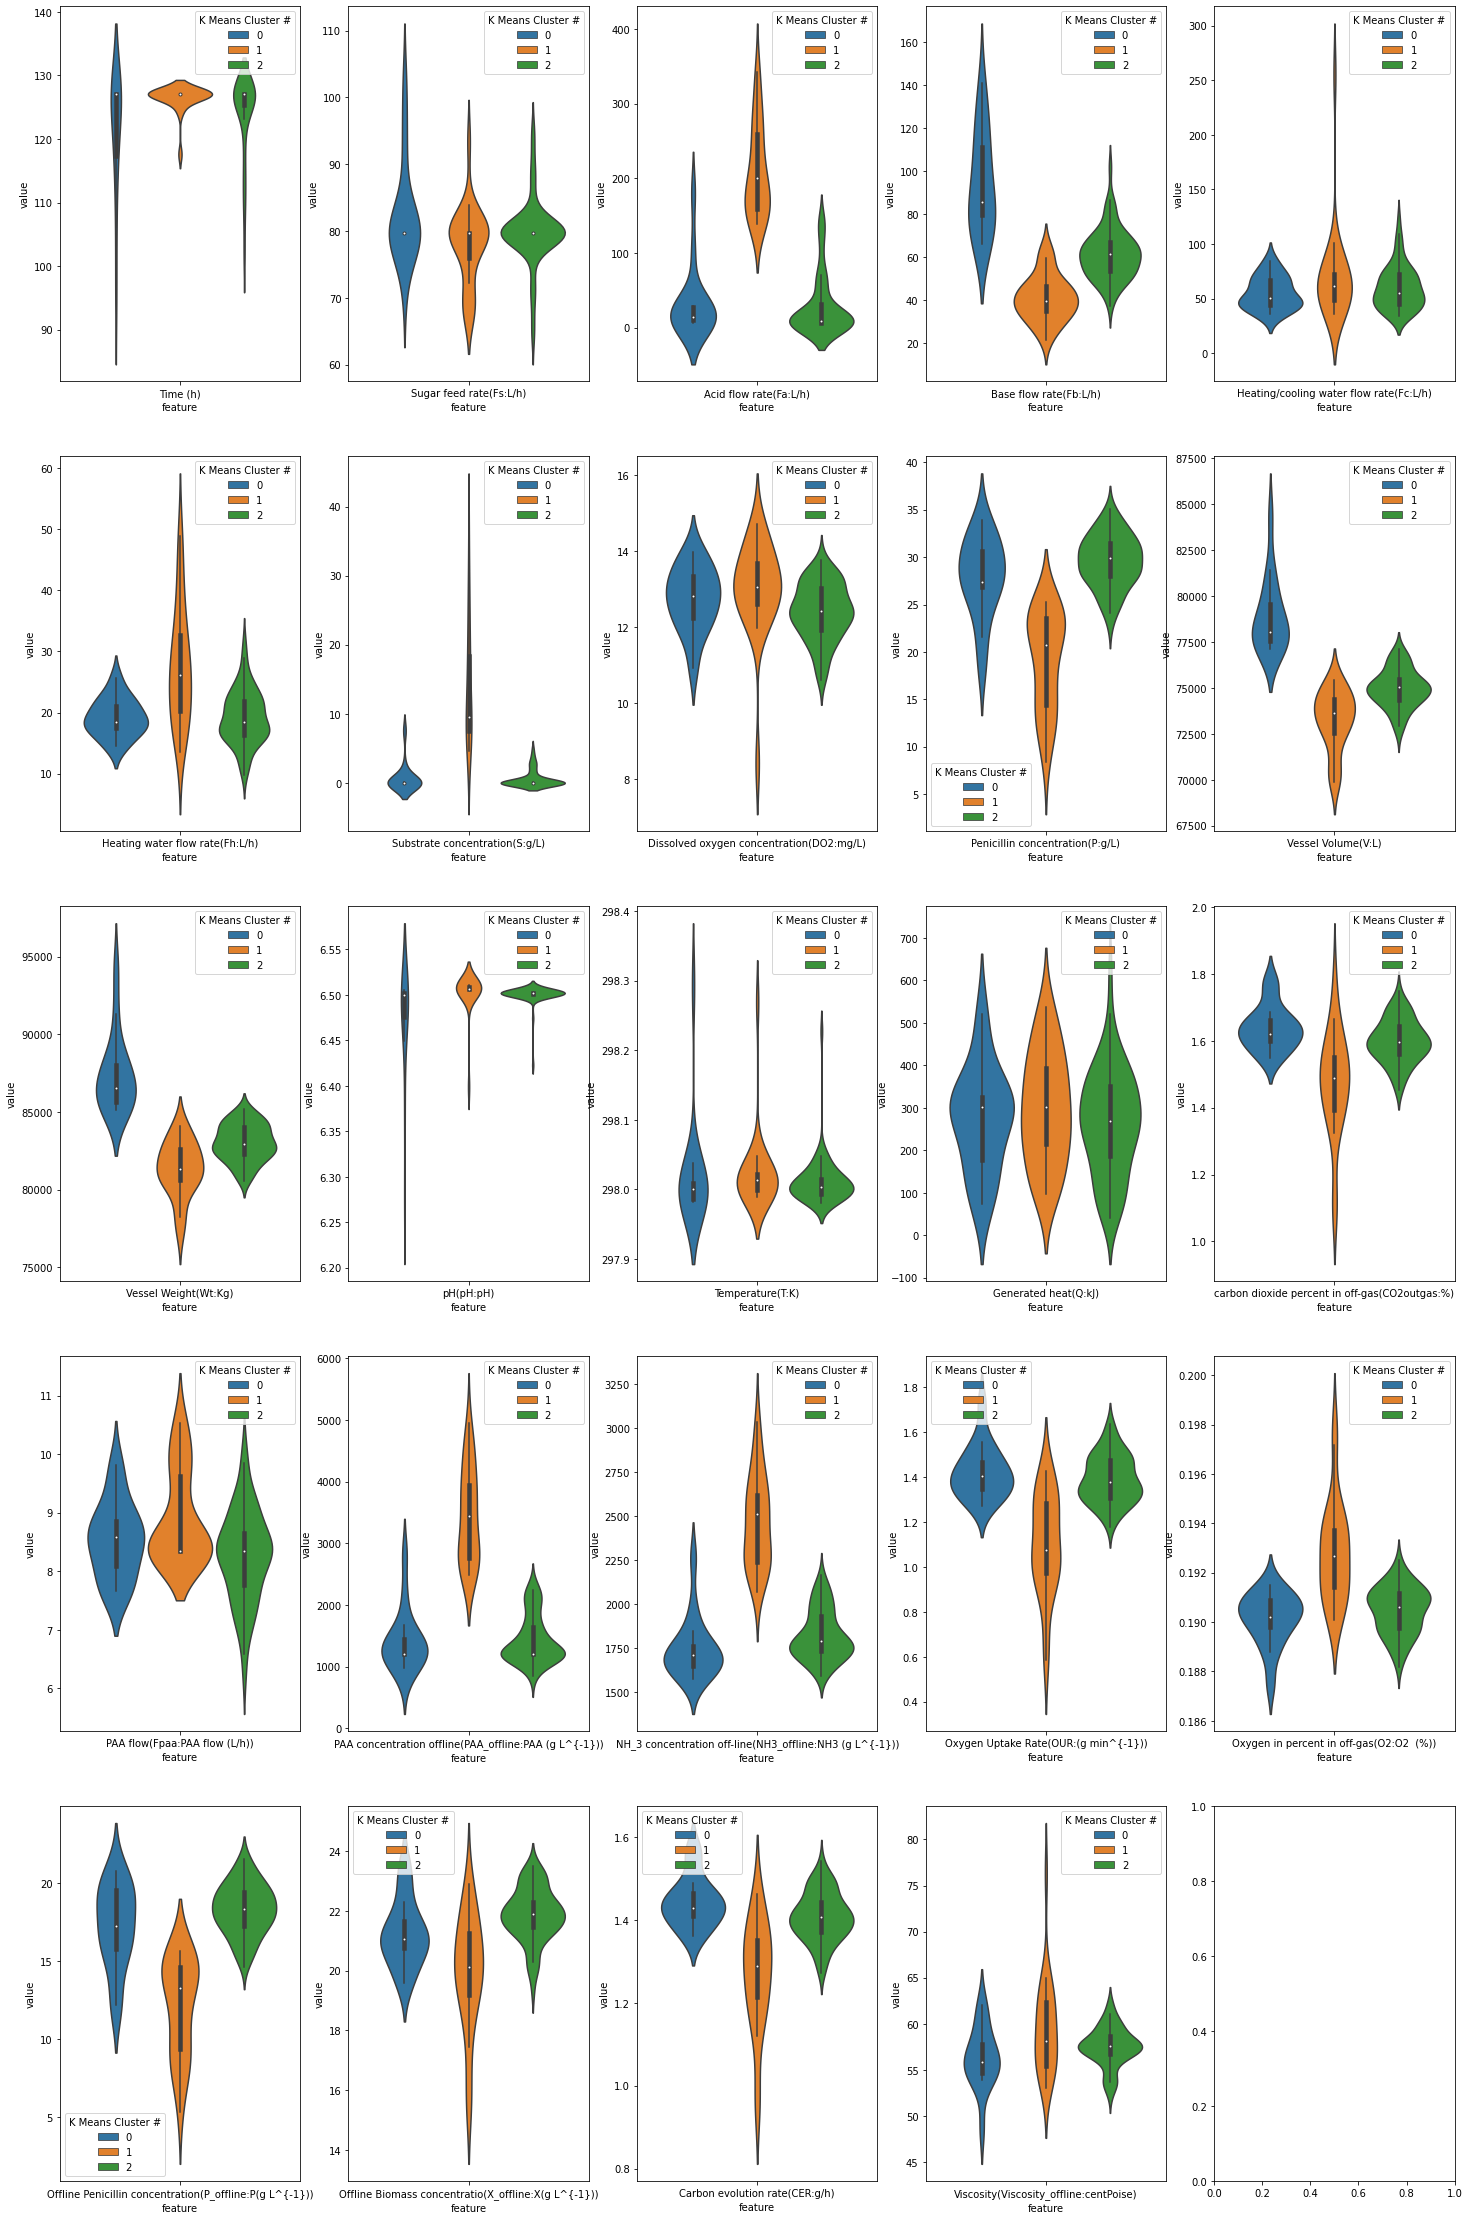

In [316]:
# visualize variable behaviors for each clusters
feat_evaluate = ['Time (h)', 'Sugar feed rate(Fs:L/h)', 'Acid flow rate(Fa:L/h)',
       'Base flow rate(Fb:L/h)', 'Heating/cooling water flow rate(Fc:L/h)',
       'Heating water flow rate(Fh:L/h)', 'Substrate concentration(S:g/L)',
       'Dissolved oxygen concentration(DO2:mg/L)',
       'Penicillin concentration(P:g/L)', 'Vessel Volume(V:L)',
       'Vessel Weight(Wt:Kg)', 'pH(pH:pH)', 'Temperature(T:K)',
       'Generated heat(Q:kJ)',
       'carbon dioxide percent in off-gas(CO2outgas:%)',
       'PAA flow(Fpaa:PAA flow (L/h))',
       'PAA concentration offline(PAA_offline:PAA (g L^{-1}))',
       'NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))',
       'Oxygen Uptake Rate(OUR:(g min^{-1}))',
       'Oxygen in percent in off-gas(O2:O2  (%))',
       'Offline Penicillin concentration(P_offline:P(g L^{-1}))',
       'Offline Biomass concentratio(X_offline:X(g L^{-1}))',
       'Carbon evolution rate(CER:g/h)',
       'Viscosity(Viscosity_offline:centPoise)']
fig, ax = plt.subplots(5,5,figsize=(25,40))

for i, ax in zip(range(len(feat_evaluate)), ax.flatten()):
  df = df_with_pca_cluster[[feat_evaluate[i], "K Means Cluster #"]]
  df_long = pd.melt(df, "K Means Cluster #", var_name="feature", value_name="value")
  sns.violinplot(x="feature", hue="K Means Cluster #", y="value", data=df_long, ax=ax)

PCA-enabled (to reduce the noise if possible) k means clustering demonstrates similar findings as I did in the earlier EDA. cluster 0 and 2, which is showing the best result in penicillin concentration demonstrates similar behavior among different process variable as recommended previously.

# 4. Final Conclusion and Remarks

In this preliminary study, different subsets of batch were divided depnding on 2 different the penicillin generation trajectory, and with an effort to find the best possible combination of variable, grouping analysis of the steady state penicillin concentration batch sets were conducted. 


Dataset was parsed and column headers that were misaligned was fixed, and further data cleaning was performed to ensure correct analysis. Furthermore, to simplify the complicated format of the batch data, the data aggregation per batch was performed to represent the final condition of each batch for the grouping analysis.


Batch 48 was demonstrating the best result of yielding highest penicillin concentration, which demonstrates its process/predictor variable as it was shown in the above analysis.


After the study, I came to know that to ensure that the ideal penicillin yield, it is important to set up process variables that ensures to reach steady state operation. to achieve this:

    1.1 Lower usage of total acid flow

    1.2 Do not undersupply the base flow

    1.3 Do not oversupply the heating water flow (don't overheat your vessel)

    1.4 Maintain 12 - 13 mg/L dissovlved oxygen concentration

    1.5 Avoid pH damping or undershooting spikes

    1.6 Ensure CO2 percent in a purge gas is moderately maintained around 1.5 - 1.6% on average

    1.7 7 - 8 L/h of PAA flow

    1.8 Avoid high average of PAA concentration and NH3 concentration from the offline process samples

    1.9 Oxygen Uptake Rate between 1.3 -  1.5 g/h


If I had more resources to invest in this study, I would try modelling out the entire batch level model, and try ALE/PDP/SHAP plots to see the impact of the target variable per variable behavior in more depth.